# Classification Experiment: Tweets
---
This Notebook, includes a series of experiments, on using a node's tweets for classification.

Libraries:

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy
import json
import tweepy
import time

from tqdm.notebook import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import FeatureUnion
from sklearn.decomposition import TruncatedSVD

from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

import joblib

Twitter API Authentication:

In [2]:
twitter_credentials = []
with open('../../../../twitter_credentials.json', 'r') as f:
    twitter_credentials = json.load(f)

auth = tweepy.OAuthHandler(twitter_credentials['consumer_key'], twitter_credentials['consumer_secret'])
auth.set_access_token(twitter_credentials['access_token_key'],twitter_credentials['access_token_secret'])
API = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True, timeout=600)

Functions:

In [3]:
# Function For Fetching Tweets
def fetch_tweets(data):
    
    recent_tweet = []
    recent_10_tweets = []
    recent_100_tweets = []
    

    for screen_name in tqdm(data):
        tweet = str()
        tweet10 = str()
        tweet100 = str()
        count = 0    
        try:
            for status in tweepy.Cursor(API.user_timeline, screen_name=screen_name).items(100):
                tweet100 = tweet100 + ' ' + status.text                
                if count == 0:
                    tweet = tweet100
                if count == 10:
                    tweet10 = tweet100
                count+= 1
            
        except tweepy.RateLimitError as err:
            print('Rate Limit Hit. Wait 15min.')
            time.sleep(60*15)
            for status in tweepy.Cursor(API.user_timeline, screen_name=screen_name, extended=True).items(100):
                tweet100 = tweet100 + ' ' + status.text
                
                if count == 0:
                    tweet = tweet100
                if count == 10:
                    tweet10 = tweet100
                count+= 1
        except Exception as err:
            pass
            
        recent_tweet.append(tweet)
        recent_10_tweets.append(tweet10)   
        recent_100_tweets.append(tweet100)
            
    return (recent_tweet, recent_10_tweets, recent_100_tweets)

# Function For Text Normalization
def clean_text(data):
    urls = r'http\S+'
    non_unicode_char = r'\W'
    numbers = r'[0-9_]'
    fix_whitespace = r'\s+'
    single_whitespace = ' '
    
    data = (data.replace([urls], single_whitespace, regex=True)
                    .replace([non_unicode_char, numbers], single_whitespace, regex=True)
                    .replace(fix_whitespace, single_whitespace, regex=True))
    data = data.apply(lambda s: s.lower() if type(s) == str else s)
    return data

nlp_el = spacy.load('el_core_news_md')
nlp_en = spacy.load('en_core_web_sm')
STOPWORDS = set(list(spacy.lang.en.STOP_WORDS) + list(spacy.lang.el.STOP_WORDS))

def remove_stopwords(row):
    row = [str(token) for token in nlp_el(row)]
    return [w for w in row if w not in STOPWORDS]

def tokenize_lemmatize(row):
    return [str(token.lemma_) for token in nlp_el(row)]

# Function For Support Vector Machine
def classification_svm(X, y, vect):
    if vect == 'TF-IDF':
        pipeline = Pipeline([
            ('vectorizer', TfidfVectorizer()),
            ('svm', svm.SVC())
        ]
        )
    elif vect == 'BoW':
        pipeline = Pipeline([
            ('vectorizer', CountVectorizer()),
            ('svm', svm.SVC())
        ]
        )

    parameters = {'vectorizer__max_df': [0.25, 0.5, 0.75, 1],
                  'vectorizer__min_df': [1, 5, 10, 25],
                  'vectorizer__max_features': [10, 100, 1000, 2000, None],
                  'svm__C' : [0.1,0.5,1,5,10],
                  'svm__kernel':['linear', 'poly', 'rbf', 'sigmoid']
                  }
    
    grid = GridSearchCV(pipeline, parameters, n_jobs = 4)
    grid.fit(X, y)
    
    print(grid.best_params_)
    return grid.best_score_

# Function For Logistic Regression
def classification_lr(X, y, vect):
    if vect == 'TF-IDF':
        pipeline = Pipeline([
            ('vectorizer', TfidfVectorizer()),
            ('lr', LogisticRegression(max_iter=1000))
        ]
        )
    elif vect == 'BoW':
        pipeline = Pipeline([
            ('vectorizer', CountVectorizer()),
            ('lr', LogisticRegression(max_iter=1000))
        ]
        )

    parameters = {'vectorizer__max_df': [0.25, 0.5, 0.75, 1],
                  'vectorizer__min_df': [1, 5, 10, 25],
                  'vectorizer__max_features': [10, 100, 1000, 2000, None],
                  'lr__penalty': ['l1', 'l2', 'elasticnet', 'none'],
                  'lr__C': [0.1, 0.5, 1, 5, 10]
                  }
    
    grid = GridSearchCV(pipeline, parameters, n_jobs = 4)
    grid.fit(X, y)
    
    print(grid.best_params_)
    return grid.best_score_

# Function For kNN
def classification_knn(X, y, vect):
    if vect == 'TF-IDF':
        pipeline = Pipeline([
            ('vectorizer', TfidfVectorizer()),
            ('knn', KNeighborsClassifier())
        ]
        )
    elif vect == 'BoW':
        pipeline = Pipeline([
            ('vectorizer', CountVectorizer()),
            ('knn', KNeighborsClassifier())
        ]
        )

    parameters = {'vectorizer__max_df': [0.25, 0.5, 0.75, 1],
                  'vectorizer__min_df': [1, 5, 10, 25],
                  'vectorizer__max_features': [10, 100, 1000, 2000, None],
                  'knn__n_neighbors': [1,2,3,4,5,6,7,8,9,10],
                  'knn__weights': ['uniform', 'distance']
                  }
    
    grid = GridSearchCV(pipeline, parameters, n_jobs = 4)
    grid.fit(X, y)
    
    print(grid.best_params_)
    return grid.best_score_


def get_text_data_nd(df):
    df['textdata'] = clean_text(df['name'] + ' ' + df['description'])
    df['textdata'] = df['textdata'].apply(lambda row: tokenize_lemmatize(row))
    df['textdata'] = df['textdata'].apply(lambda row: ' '.join(row))
    df['textdata'] = df['textdata'].apply(lambda row: remove_stopwords(row))
    df['textdata'] = df['textdata'].apply(lambda row: ' '.join(row))
    
    return df.textdata


# Dataset
---

To begin with, we read our datasets, and fetch some tweets for each node creating 3 new fields:
- recent_tweet
- recent_10_tweets
- recent_100_tweets

In [4]:
# Read Training Set
training_set = pd.read_csv('../../../../datasets/Greek Politicians/classification/parliament_members_training_set.csv')
training_set = training_set.replace(np.nan, '')

In [5]:
tweets = fetch_tweets(training_set['screen_name'])

  0%|          | 0/300 [00:00<?, ?it/s]

In [6]:
training_set['recent_tweet'] = tweets[0]
training_set['recent_10_tweets'] = tweets[1]
training_set['recent_100_tweets'] = tweets[2]
training_set.head()

,screen_name,name,description,statuses_count,parliament_member,recent_tweet,recent_10_tweets,recent_100_tweets
0,evefthym,Ευάγγελος Ευθυμίου,Καναλάκι \nΠάργα \nΙωάννινα,135,0,#NewProfilePic https://t.co/h0wlMIS6U0,#NewProfilePic https://t.co/h0wlMIS6U0 @wavyp...,#NewProfilePic https://t.co/h0wlMIS6U0 @wavyp...
1,Qdv6zNFe0nkBH2m,Χριστίνα Κεραμεως,Χιούμορ,0,0,,,
2,michail_pana,Μιχαήλ Παναγιωτόπουλος,Απόστρατος Ναύαρχος του Πολέμικού Ναυτικού.\nΜ...,368,0,@odyssefs357 Γιατί έτσι όπως έγινε δεν παίρνε...,@odyssefs357 Γιατί έτσι όπως έγινε δεν παίρνε...,@odyssefs357 Γιατί έτσι όπως έγινε δεν παίρνε...
3,spirtzisforever,Χρήστος not Σπίρτζης,Parody account/Fan account του πιο ερωτικού βο...,7,0,"@NasosNot Επι ΠΑΣΟΚ είχαμε κλαδικές, αυτό ήτα...",,"@NasosNot Επι ΠΑΣΟΚ είχαμε κλαδικές, αυτό ήτα..."
4,FdZwMqKWXciTydT,Ειρήνη Γκαρα,,1,0,Καλό βράδυ!!!!,,Καλό βράδυ!!!!


# Case 1: name + description + tweets
---
In this case, we use a node's name, description and tweets as a single feature to classify the node.

## Text Normalization
We start by creating 3 new fields:
- textdata_1 : name + description + recent_tweet
- textdata_2 : name + description + recent_10_tweets
- textdata_3 : name + description + recent_100_tweets

In [7]:
data = training_set.copy()
data['textdata_1'] = data['name'] + ' ' + data['description'] + ' ' + data['recent_tweet']
data['textdata_2'] = data['name'] + ' ' + data['description'] + ' ' + data['recent_10_tweets']
data['textdata_3'] = data['name'] + ' ' + data['description'] + ' ' + data['recent_100_tweets']
data = data.drop(['name', 'description', 'statuses_count', 'recent_tweet', 'recent_10_tweets', 'recent_100_tweets'], axis = 1)
data.head(3)

,screen_name,parliament_member,textdata_1,textdata_2,textdata_3
0,evefthym,0,Ευάγγελος Ευθυμίου Καναλάκι \nΠάργα \nΙωάννινα...,Ευάγγελος Ευθυμίου Καναλάκι \nΠάργα \nΙωάννινα...,Ευάγγελος Ευθυμίου Καναλάκι \nΠάργα \nΙωάννινα...
1,Qdv6zNFe0nkBH2m,0,Χριστίνα Κεραμεως Χιούμορ,Χριστίνα Κεραμεως Χιούμορ,Χριστίνα Κεραμεως Χιούμορ
2,michail_pana,0,Μιχαήλ Παναγιωτόπουλος Απόστρατος Ναύαρχος του...,Μιχαήλ Παναγιωτόπουλος Απόστρατος Ναύαρχος του...,Μιχαήλ Παναγιωτόπουλος Απόστρατος Ναύαρχος του...


Next normalize our text by taking the following actions:

- remove URLs
- remove Mentions
- remove anything that isn't a unicode character (e.g emojis, punctuation)
- remove numbers and _
- fix whitespace
- convert to lower case

In [8]:
data['textdata_1'] = clean_text(data['textdata_1'])
data['textdata_2'] = clean_text(data['textdata_2'])
data['textdata_3'] = clean_text(data['textdata_3'])

## Model Selection

In [9]:
svm_tfidf = pd.DataFrame()
svm_bow = pd.DataFrame()

lr_tfidf = pd.DataFrame()
lr_bow = pd.DataFrame()

knn_tfidf = pd.DataFrame()
knn_bow = pd.DataFrame()

### Without NLP

In [10]:
textdatas = ['textdata_1', 'textdata_2', 'textdata_3']

#### SVM

In [11]:
# TF-IDF 
results = {}
for textdata in tqdm(textdatas):
    print(f'Best params for {textdata}:')
    X = data[textdata]
    results[textdata] = classification_svm(X, data['parliament_member'], 'TF-IDF').round(4)
    print("============================")
    
svm_tfidf = svm_tfidf.append(
    pd.DataFrame.from_dict(results, orient='index', columns=['Without NLP']).T)

svm_tfidf

  0%|          | 0/3 [00:00<?, ?it/s]

Best params for textdata_1:


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.55 0.55 0.55 ...  nan  nan  nan]
  warnings.warn(


{'svm__C': 1, 'svm__kernel': 'linear', 'vectorizer__max_df': 0.5, 'vectorizer__max_features': None, 'vectorizer__min_df': 1}
Best params for textdata_2:


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.56 0.56 0.56 ...  nan  nan  nan]
  warnings.warn(


{'svm__C': 10, 'svm__kernel': 'linear', 'vectorizer__max_df': 0.5, 'vectorizer__max_features': 2000, 'vectorizer__min_df': 1}
Best params for textdata_3:


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.64333333 0.64333333 0.64333333 ...        nan        nan        nan]
  warnings.warn(


{'svm__C': 5, 'svm__kernel': 'linear', 'vectorizer__max_df': 0.5, 'vectorizer__max_features': None, 'vectorizer__min_df': 1}


,textdata_1,textdata_2,textdata_3
Without NLP,0.88,0.88,0.91


In [12]:
# BoW
results = {}
for textdata in tqdm(textdatas):
    print(f'Best params for {textdata}:')
    X = data[textdata]
    results[textdata] = classification_svm(X, data['parliament_member'], 'BoW').round(4)
    print("============================")
    
svm_bow = svm_bow.append(
    pd.DataFrame.from_dict(results, orient='index', columns=['Without NLP']).T)

svm_bow

  0%|          | 0/3 [00:00<?, ?it/s]

Best params for textdata_1:


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.55 0.55 0.55 ...  nan  nan  nan]
  warnings.warn(


{'svm__C': 1, 'svm__kernel': 'linear', 'vectorizer__max_df': 0.5, 'vectorizer__max_features': 100, 'vectorizer__min_df': 10}
Best params for textdata_2:


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.60333333 0.60333333 0.60333333 ...        nan        nan        nan]
  warnings.warn(


{'svm__C': 0.1, 'svm__kernel': 'linear', 'vectorizer__max_df': 0.5, 'vectorizer__max_features': 1000, 'vectorizer__min_df': 10}
Best params for textdata_3:


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.70666667 0.70666667 0.70666667 ...        nan        nan        nan]
  warnings.warn(


{'svm__C': 0.1, 'svm__kernel': 'linear', 'vectorizer__max_df': 0.75, 'vectorizer__max_features': None, 'vectorizer__min_df': 5}


,textdata_1,textdata_2,textdata_3
Without NLP,0.8767,0.8667,0.8633


#### Logistic Regression

In [13]:
# TF-IDF 
results = {}
for textdata in tqdm(textdatas):
    print(f'Best params for {textdata}:')
    X = data[textdata]
    results[textdata] = classification_lr(X, data['parliament_member'], 'TF-IDF').round(4)
    print("============================")
    
lr_tfidf = lr_tfidf.append(
    pd.DataFrame.from_dict(results, orient='index', columns=['Without NLP']).T)

lr_tfidf

  0%|          | 0/3 [00:00<?, ?it/s]

Best params for textdata_1:


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [nan nan nan ... nan nan nan]
  warnings.warn(


{'lr__C': 0.5, 'lr__penalty': 'l2', 'vectorizer__max_df': 0.5, 'vectorizer__max_features': None, 'vectorizer__min_df': 1}
Best params for textdata_2:


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [nan nan nan ... nan nan nan]
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


{'lr__C': 0.1, 'lr__penalty': 'none', 'vectorizer__max_df': 0.75, 'vectorizer__max_features': 2000, 'vectorizer__min_df': 1}
Best params for textdata_3:


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [nan nan nan ... nan nan nan]
  warnings.warn(


{'lr__C': 0.1, 'lr__penalty': 'none', 'vectorizer__max_df': 0.5, 'vectorizer__max_features': None, 'vectorizer__min_df': 1}


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


,textdata_1,textdata_2,textdata_3
Without NLP,0.87,0.8733,0.9


In [14]:
# BoW
results = {}
for textdata in tqdm(textdatas):
    print(f'Best params for {textdata}:')
    X = data[textdata]
    results[textdata] = classification_lr(X, data['parliament_member'], 'BoW').round(4)
    print("============================")
    
lr_bow = lr_bow.append(
    pd.DataFrame.from_dict(results, orient='index', columns=['Without NLP']).T)

lr_bow

  0%|          | 0/3 [00:00<?, ?it/s]

Best params for textdata_1:


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [nan nan nan ... nan nan nan]
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


{'lr__C': 0.1, 'lr__penalty': 'none', 'vectorizer__max_df': 0.5, 'vectorizer__max_features': None, 'vectorizer__min_df': 1}
Best params for textdata_2:


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [nan nan nan ... nan nan nan]
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


{'lr__C': 0.1, 'lr__penalty': 'none', 'vectorizer__max_df': 0.75, 'vectorizer__max_features': None, 'vectorizer__min_df': 1}
Best params for textdata_3:


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [nan nan nan ... nan nan nan]
  warnings.warn(


{'lr__C': 0.5, 'lr__penalty': 'l2', 'vectorizer__max_df': 0.5, 'vectorizer__max_features': None, 'vectorizer__min_df': 5}


,textdata_1,textdata_2,textdata_3
Without NLP,0.8867,0.8767,0.8867


#### kNN

In [15]:
# TF-IDF 
results = {}
for textdata in tqdm(textdatas):
    print(f'Best params for {textdata}:')
    X = data[textdata]
    results[textdata] = classification_knn(X, data['parliament_member'], 'TF-IDF').round(4)
    print("============================")
    
knn_tfidf = knn_tfidf.append(
    pd.DataFrame.from_dict(results, orient='index', columns=['Without NLP']).T)

knn_tfidf

  0%|          | 0/3 [00:00<?, ?it/s]

Best params for textdata_1:


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.54 0.54 0.54 ...  nan  nan  nan]
  warnings.warn(


{'knn__n_neighbors': 8, 'knn__weights': 'uniform', 'vectorizer__max_df': 0.5, 'vectorizer__max_features': 2000, 'vectorizer__min_df': 1}
Best params for textdata_2:


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.59333333 0.59333333 0.59333333 ...        nan        nan        nan]
  warnings.warn(


{'knn__n_neighbors': 8, 'knn__weights': 'distance', 'vectorizer__max_df': 0.25, 'vectorizer__max_features': None, 'vectorizer__min_df': 1}
Best params for textdata_3:


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.56666667 0.56666667 0.56666667 ...        nan        nan        nan]
  warnings.warn(


{'knn__n_neighbors': 1, 'knn__weights': 'uniform', 'vectorizer__max_df': 0.5, 'vectorizer__max_features': 100, 'vectorizer__min_df': 25}


,textdata_1,textdata_2,textdata_3
Without NLP,0.8567,0.8333,0.8767


In [16]:
# BoW
results = {}
for textdata in tqdm(textdatas):
    print(f'Best params for {textdata}:')
    X = data[textdata]
    results[textdata] = classification_knn(X, data['parliament_member'], 'BoW').round(4)
    print("============================")
    
knn_bow = knn_bow.append(
    pd.DataFrame.from_dict(results, orient='index', columns=['Without NLP']).T)

knn_bow

  0%|          | 0/3 [00:00<?, ?it/s]

Best params for textdata_1:


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.53666667 0.53666667 0.53666667 ...        nan        nan        nan]
  warnings.warn(


{'knn__n_neighbors': 9, 'knn__weights': 'distance', 'vectorizer__max_df': 0.5, 'vectorizer__max_features': 100, 'vectorizer__min_df': 25}
Best params for textdata_2:


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.60333333 0.60333333 0.60333333 ...        nan        nan        nan]
  warnings.warn(


{'knn__n_neighbors': 6, 'knn__weights': 'distance', 'vectorizer__max_df': 0.5, 'vectorizer__max_features': 100, 'vectorizer__min_df': 10}
Best params for textdata_3:


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.57333333 0.57333333 0.57333333 ...        nan        nan        nan]
  warnings.warn(


{'knn__n_neighbors': 3, 'knn__weights': 'distance', 'vectorizer__max_df': 0.5, 'vectorizer__max_features': 100, 'vectorizer__min_df': 1}


,textdata_1,textdata_2,textdata_3
Without NLP,0.8467,0.7933,0.85


### Stop Word Removal

In [11]:
nlp_el = spacy.load('el_core_news_md')
nlp_en = spacy.load('en_core_web_sm')
STOPWORDS = set(list(spacy.lang.en.STOP_WORDS) + list(spacy.lang.el.STOP_WORDS))

def remove_stopwords(row):
    row = [str(token) for token in nlp_el(row)]
    return [w for w in row if w not in STOPWORDS]

In [18]:
df = data.copy()

df['textdata_1'] = df['textdata_1'].apply(lambda row: remove_stopwords(row))
df['textdata_1'] = df['textdata_1'].apply(lambda row: ' '.join(row))

df['textdata_2'] = df['textdata_2'].apply(lambda row: remove_stopwords(row))
df['textdata_2'] = df['textdata_2'].apply(lambda row: ' '.join(row))

df['textdata_3'] = df['textdata_3'].apply(lambda row: remove_stopwords(row))
df['textdata_3'] = df['textdata_3'].apply(lambda row: ' '.join(row))

#### SVM

In [19]:
# TF-IDF 
results = {}
for textdata in tqdm(textdatas):
    print(f'Best params for {textdata}:')
    X = df[textdata]
    results[textdata] = classification_svm(X, df['parliament_member'], 'TF-IDF').round(4)
    print("============================")
    
svm_tfidf = svm_tfidf.append(
    pd.DataFrame.from_dict(results, orient='index', columns=['Stopword Removal']).T)

svm_tfidf

  0%|          | 0/3 [00:00<?, ?it/s]

Best params for textdata_1:


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.72 0.72 0.72 ...  nan  nan  nan]
  warnings.warn(


{'svm__C': 0.5, 'svm__kernel': 'linear', 'vectorizer__max_df': 0.5, 'vectorizer__max_features': 1000, 'vectorizer__min_df': 1}
Best params for textdata_2:


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.65666667 0.66       0.67       ...        nan        nan        nan]
  warnings.warn(


{'svm__C': 1, 'svm__kernel': 'sigmoid', 'vectorizer__max_df': 0.5, 'vectorizer__max_features': 1000, 'vectorizer__min_df': 1}
Best params for textdata_3:


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.59666667 0.59666667 0.6        ...        nan        nan        nan]
  warnings.warn(


{'svm__C': 5, 'svm__kernel': 'linear', 'vectorizer__max_df': 0.75, 'vectorizer__max_features': None, 'vectorizer__min_df': 1}


,textdata_1,textdata_2,textdata_3
Without NLP,0.88,0.8800,0.9100
Stopword Removal,0.90,0.8767,0.9167


In [20]:
# BoW
results = {}
for textdata in tqdm(textdatas):
    print(f'Best params for {textdata}:')
    X = df[textdata]
    results[textdata] = classification_svm(X, df['parliament_member'], 'BoW').round(4)
    print("============================")
    
svm_bow = svm_bow.append(
    pd.DataFrame.from_dict(results, orient='index', columns=['Stopword Removal']).T)

svm_bow

  0%|          | 0/3 [00:00<?, ?it/s]

Best params for textdata_1:


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.68333333 0.68333333 0.68333333 ...        nan        nan        nan]
  warnings.warn(


{'svm__C': 1, 'svm__kernel': 'rbf', 'vectorizer__max_df': 0.5, 'vectorizer__max_features': 100, 'vectorizer__min_df': 1}
Best params for textdata_2:


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.63666667 0.63666667 0.63666667 ...        nan        nan        nan]
  warnings.warn(


{'svm__C': 0.5, 'svm__kernel': 'linear', 'vectorizer__max_df': 0.5, 'vectorizer__max_features': 2000, 'vectorizer__min_df': 1}
Best params for textdata_3:


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.64 0.64 0.65 ...  nan  nan  nan]
  warnings.warn(


{'svm__C': 1, 'svm__kernel': 'linear', 'vectorizer__max_df': 0.75, 'vectorizer__max_features': None, 'vectorizer__min_df': 1}


,textdata_1,textdata_2,textdata_3
Without NLP,0.8767,0.8667,0.8633
Stopword Removal,0.8967,0.8967,0.8933


#### Logistic Regression

In [21]:
# TF-IDF 
results = {}
for textdata in tqdm(textdatas):
    print(f'Best params for {textdata}:')
    X = df[textdata]
    results[textdata] = classification_lr(X, df['parliament_member'], 'TF-IDF').round(4)
    print("============================")
    
lr_tfidf = lr_tfidf.append(
    pd.DataFrame.from_dict(results, orient='index', columns=['Stopword Removal']).T)

lr_tfidf

  0%|          | 0/3 [00:00<?, ?it/s]

Best params for textdata_1:


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [nan nan nan ... nan nan nan]
  warnings.warn(


{'lr__C': 0.1, 'lr__penalty': 'l2', 'vectorizer__max_df': 0.5, 'vectorizer__max_features': 2000, 'vectorizer__min_df': 1}
Best params for textdata_2:


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [nan nan nan ... nan nan nan]
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


{'lr__C': 0.1, 'lr__penalty': 'none', 'vectorizer__max_df': 0.5, 'vectorizer__max_features': 10, 'vectorizer__min_df': 10}
Best params for textdata_3:


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [nan nan nan ... nan nan nan]
  warnings.warn(


{'lr__C': 0.1, 'lr__penalty': 'none', 'vectorizer__max_df': 0.75, 'vectorizer__max_features': 2000, 'vectorizer__min_df': 5}


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


,textdata_1,textdata_2,textdata_3
Without NLP,0.87,0.8733,0.9000
Stopword Removal,0.91,0.8733,0.9133


In [22]:
# BoW
results = {}
for textdata in tqdm(textdatas):
    print(f'Best params for {textdata}:')
    X = df[textdata]
    results[textdata] = classification_lr(X, df['parliament_member'], 'BoW').round(4)
    print("============================")
    
lr_bow = lr_bow.append(
    pd.DataFrame.from_dict(results, orient='index', columns=['Stopword Removal']).T)

lr_bow

  0%|          | 0/3 [00:00<?, ?it/s]

Best params for textdata_1:


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [nan nan nan ... nan nan nan]
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


{'lr__C': 0.1, 'lr__penalty': 'none', 'vectorizer__max_df': 0.5, 'vectorizer__max_features': 2000, 'vectorizer__min_df': 1}
Best params for textdata_2:


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [nan nan nan ... nan nan nan]
  warnings.warn(


{'lr__C': 0.1, 'lr__penalty': 'l2', 'vectorizer__max_df': 0.5, 'vectorizer__max_features': 2000, 'vectorizer__min_df': 1}
Best params for textdata_3:


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [nan nan nan ... nan nan nan]
  warnings.warn(


{'lr__C': 0.1, 'lr__penalty': 'none', 'vectorizer__max_df': 0.75, 'vectorizer__max_features': 2000, 'vectorizer__min_df': 1}


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


,textdata_1,textdata_2,textdata_3
Without NLP,0.8867,0.8767,0.8867
Stopword Removal,0.9000,0.8767,0.9133


#### kNN

In [23]:
# TF-IDF 
results = {}
for textdata in tqdm(textdatas):
    print(f'Best params for {textdata}:')
    X = df[textdata]
    results[textdata] = classification_knn(X, df['parliament_member'], 'TF-IDF').round(4)
    print("============================")
    
knn_tfidf = knn_tfidf.append(
    pd.DataFrame.from_dict(results, orient='index', columns=['Stopword Removal']).T)

knn_tfidf

  0%|          | 0/3 [00:00<?, ?it/s]

Best params for textdata_1:


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.66333333 0.67666667 0.67333333 ...        nan        nan        nan]
  warnings.warn(


{'knn__n_neighbors': 1, 'knn__weights': 'uniform', 'vectorizer__max_df': 0.5, 'vectorizer__max_features': 100, 'vectorizer__min_df': 10}
Best params for textdata_2:


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.66666667 0.67333333 0.68333333 ...        nan        nan        nan]
  warnings.warn(


{'knn__n_neighbors': 1, 'knn__weights': 'uniform', 'vectorizer__max_df': 0.5, 'vectorizer__max_features': 10, 'vectorizer__min_df': 25}
Best params for textdata_3:


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.61333333 0.61333333 0.61666667 ...        nan        nan        nan]
  warnings.warn(


{'knn__n_neighbors': 8, 'knn__weights': 'uniform', 'vectorizer__max_df': 0.25, 'vectorizer__max_features': None, 'vectorizer__min_df': 1}


,textdata_1,textdata_2,textdata_3
Without NLP,0.8567,0.8333,0.8767
Stopword Removal,0.8867,0.8467,0.8933


In [24]:
# BoW
results = {}
for textdata in tqdm(textdatas):
    print(f'Best params for {textdata}:')
    X = df[textdata]
    results[textdata] = classification_knn(X, df['parliament_member'], 'BoW').round(4)
    print("============================")
    
knn_bow = knn_bow.append(
    pd.DataFrame.from_dict(results, orient='index', columns=['Stopword Removal']).T)

knn_bow

  0%|          | 0/3 [00:00<?, ?it/s]

Best params for textdata_1:


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.65       0.65666667 0.66       ...        nan        nan        nan]
  warnings.warn(


{'knn__n_neighbors': 3, 'knn__weights': 'distance', 'vectorizer__max_df': 0.5, 'vectorizer__max_features': 10, 'vectorizer__min_df': 5}
Best params for textdata_2:


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.64333333 0.64333333 0.65       ...        nan        nan        nan]
  warnings.warn(


{'knn__n_neighbors': 5, 'knn__weights': 'distance', 'vectorizer__max_df': 0.5, 'vectorizer__max_features': 10, 'vectorizer__min_df': 25}
Best params for textdata_3:


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.62       0.62       0.62333333 ...        nan        nan        nan]
  warnings.warn(


{'knn__n_neighbors': 1, 'knn__weights': 'uniform', 'vectorizer__max_df': 0.5, 'vectorizer__max_features': 100, 'vectorizer__min_df': 1}


,textdata_1,textdata_2,textdata_3
Without NLP,0.8467,0.7933,0.8500
Stopword Removal,0.8767,0.8233,0.8533


### Lemmatization

In [27]:
def tokenize_lemmatize(row):
    return [str(token.lemma_) for token in nlp_el(row)]

In [26]:
df = data.copy()

df['textdata_1'] = df['textdata_1'].apply(lambda row: tokenize_lemmatize(row))
df['textdata_1'] = df['textdata_1'].apply(lambda row: ' '.join(row))
df['textdata_1'] = df['textdata_1'].apply(lambda row: remove_stopwords(row))
df['textdata_1'] = df['textdata_1'].apply(lambda row: ' '.join(row))

df['textdata_2'] = df['textdata_2'].apply(lambda row: tokenize_lemmatize(row))
df['textdata_2'] = df['textdata_2'].apply(lambda row: ' '.join(row))
df['textdata_2'] = df['textdata_2'].apply(lambda row: remove_stopwords(row))
df['textdata_2'] = df['textdata_2'].apply(lambda row: ' '.join(row))

df['textdata_3'] = df['textdata_3'].apply(lambda row: tokenize_lemmatize(row))
df['textdata_3'] = df['textdata_3'].apply(lambda row: ' '.join(row))
df['textdata_3'] = df['textdata_3'].apply(lambda row: remove_stopwords(row))
df['textdata_3'] = df['textdata_3'].apply(lambda row: ' '.join(row))

#### SVM

In [27]:
# TF-IDF 
results = {}
for textdata in tqdm(textdatas):
    print(f'Best params for {textdata}:')
    X = df[textdata]
    results[textdata] = classification_svm(X, df['parliament_member'], 'TF-IDF').round(4)
    print("============================")
    
svm_tfidf = svm_tfidf.append(
    pd.DataFrame.from_dict(results, orient='index', columns=['Lemmatization']).T)

svm_tfidf

  0%|          | 0/3 [00:00<?, ?it/s]

Best params for textdata_1:


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.67333333 0.68       0.67666667 ...        nan        nan        nan]
  warnings.warn(


{'svm__C': 1, 'svm__kernel': 'rbf', 'vectorizer__max_df': 0.5, 'vectorizer__max_features': 2000, 'vectorizer__min_df': 1}
Best params for textdata_2:


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.61       0.62333333 0.62333333 ...        nan        nan        nan]
  warnings.warn(


{'svm__C': 1, 'svm__kernel': 'sigmoid', 'vectorizer__max_df': 0.5, 'vectorizer__max_features': 2000, 'vectorizer__min_df': 1}
Best params for textdata_3:


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.64333333 0.64333333 0.64333333 ...        nan        nan        nan]
  warnings.warn(


{'svm__C': 5, 'svm__kernel': 'rbf', 'vectorizer__max_df': 0.75, 'vectorizer__max_features': 2000, 'vectorizer__min_df': 1}


,textdata_1,textdata_2,textdata_3
Without NLP,0.88,0.8800,0.9100
Stopword Removal,0.90,0.8767,0.9167
Lemmatization,0.90,0.8733,0.9233


In [28]:
# BoW
results = {}
for textdata in tqdm(textdatas):
    print(f'Best params for {textdata}:')
    X = df[textdata]
    results[textdata] = classification_svm(X, df['parliament_member'], 'BoW').round(4)
    print("============================")
    
svm_bow = svm_bow.append(
    pd.DataFrame.from_dict(results, orient='index', columns=['Lemmatization']).T)

svm_bow

  0%|          | 0/3 [00:00<?, ?it/s]

Best params for textdata_1:


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.68666667 0.68666667 0.68       ...        nan        nan        nan]
  warnings.warn(


{'svm__C': 0.5, 'svm__kernel': 'rbf', 'vectorizer__max_df': 0.5, 'vectorizer__max_features': 100, 'vectorizer__min_df': 10}
Best params for textdata_2:


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.58       0.58333333 0.57666667 ...        nan        nan        nan]
  warnings.warn(


{'svm__C': 0.5, 'svm__kernel': 'linear', 'vectorizer__max_df': 0.5, 'vectorizer__max_features': 2000, 'vectorizer__min_df': 1}
Best params for textdata_3:


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.6 0.6 0.6 ... nan nan nan]
  warnings.warn(


{'svm__C': 1, 'svm__kernel': 'linear', 'vectorizer__max_df': 0.75, 'vectorizer__max_features': None, 'vectorizer__min_df': 1}


,textdata_1,textdata_2,textdata_3
Without NLP,0.8767,0.8667,0.8633
Stopword Removal,0.8967,0.8967,0.8933
Lemmatization,0.8900,0.8667,0.8867


#### Logistic Regression

In [29]:
# TF-IDF 
results = {}
for textdata in tqdm(textdatas):
    print(f'Best params for {textdata}:')
    X = df[textdata]
    results[textdata] = classification_lr(X, df['parliament_member'], 'TF-IDF').round(4)
    print("============================")
    
lr_tfidf = lr_tfidf.append(
    pd.DataFrame.from_dict(results, orient='index', columns=['Lemmatization']).T)

lr_tfidf

  0%|          | 0/3 [00:00<?, ?it/s]

Best params for textdata_1:


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [nan nan nan ... nan nan nan]
  warnings.warn(


{'lr__C': 0.1, 'lr__penalty': 'l2', 'vectorizer__max_df': 0.5, 'vectorizer__max_features': None, 'vectorizer__min_df': 1}
Best params for textdata_2:


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [nan nan nan ... nan nan nan]
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


{'lr__C': 0.1, 'lr__penalty': 'none', 'vectorizer__max_df': 0.5, 'vectorizer__max_features': 1000, 'vectorizer__min_df': 1}
Best params for textdata_3:


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [nan nan nan ... nan nan nan]
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


{'lr__C': 0.1, 'lr__penalty': 'none', 'vectorizer__max_df': 0.75, 'vectorizer__max_features': None, 'vectorizer__min_df': 1}


,textdata_1,textdata_2,textdata_3
Without NLP,0.8700,0.8733,0.9000
Stopword Removal,0.9100,0.8733,0.9133
Lemmatization,0.9067,0.8800,0.9267


In [30]:
# BoW
results = {}
for textdata in tqdm(textdatas):
    print(f'Best params for {textdata}:')
    X = df[textdata]
    results[textdata] = classification_lr(X, df['parliament_member'], 'BoW').round(4)
    print("============================")
    
lr_bow = lr_bow.append(
    pd.DataFrame.from_dict(results, orient='index', columns=['Lemmatization']).T)

lr_bow

  0%|          | 0/3 [00:00<?, ?it/s]

Best params for textdata_1:


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [nan nan nan ... nan nan nan]
  warnings.warn(


{'lr__C': 1, 'lr__penalty': 'l2', 'vectorizer__max_df': 0.5, 'vectorizer__max_features': 1000, 'vectorizer__min_df': 1}
Best params for textdata_2:


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [nan nan nan ... nan nan nan]
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


{'lr__C': 0.1, 'lr__penalty': 'none', 'vectorizer__max_df': 0.5, 'vectorizer__max_features': None, 'vectorizer__min_df': 1}
Best params for textdata_3:


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [nan nan nan ... nan nan nan]
  warnings.warn(


{'lr__C': 0.1, 'lr__penalty': 'none', 'vectorizer__max_df': 0.75, 'vectorizer__max_features': 1000, 'vectorizer__min_df': 5}


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


,textdata_1,textdata_2,textdata_3
Without NLP,0.8867,0.8767,0.8867
Stopword Removal,0.9000,0.8767,0.9133
Lemmatization,0.8900,0.8800,0.9100


#### kNN

In [31]:
# TF-IDF 
results = {}
for textdata in tqdm(textdatas):
    print(f'Best params for {textdata}:')
    X = df[textdata]
    results[textdata] = classification_knn(X, df['parliament_member'], 'TF-IDF').round(4)
    print("============================")
    
knn_tfidf = knn_tfidf.append(
    pd.DataFrame.from_dict(results, orient='index', columns=['Lemmatization']).T)

knn_tfidf

  0%|          | 0/3 [00:00<?, ?it/s]

Best params for textdata_1:


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.69666667 0.70333333 0.69       ...        nan        nan        nan]
  warnings.warn(


{'knn__n_neighbors': 3, 'knn__weights': 'uniform', 'vectorizer__max_df': 0.5, 'vectorizer__max_features': 100, 'vectorizer__min_df': 10}
Best params for textdata_2:


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.62666667 0.63333333 0.62666667 ...        nan        nan        nan]
  warnings.warn(


{'knn__n_neighbors': 6, 'knn__weights': 'uniform', 'vectorizer__max_df': 0.25, 'vectorizer__max_features': None, 'vectorizer__min_df': 1}
Best params for textdata_3:


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.62333333 0.62333333 0.62333333 ...        nan        nan        nan]
  warnings.warn(


{'knn__n_neighbors': 4, 'knn__weights': 'uniform', 'vectorizer__max_df': 0.25, 'vectorizer__max_features': None, 'vectorizer__min_df': 1}


,textdata_1,textdata_2,textdata_3
Without NLP,0.8567,0.8333,0.8767
Stopword Removal,0.8867,0.8467,0.8933
Lemmatization,0.8900,0.8233,0.9133


In [32]:
# BoW
results = {}
for textdata in tqdm(textdatas):
    print(f'Best params for {textdata}:')
    X = df[textdata]
    results[textdata] = classification_knn(X, df['parliament_member'], 'BoW').round(4)
    print("============================")
    
knn_bow = knn_bow.append(
    pd.DataFrame.from_dict(results, orient='index', columns=['Lemmatization']).T)
knn_bow

  0%|          | 0/3 [00:00<?, ?it/s]

Best params for textdata_1:


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.68666667 0.69666667 0.68       ...        nan        nan        nan]
  warnings.warn(


{'knn__n_neighbors': 1, 'knn__weights': 'uniform', 'vectorizer__max_df': 0.5, 'vectorizer__max_features': 100, 'vectorizer__min_df': 10}
Best params for textdata_2:


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.61       0.62       0.62333333 ...        nan        nan        nan]
  warnings.warn(


{'knn__n_neighbors': 7, 'knn__weights': 'distance', 'vectorizer__max_df': 0.5, 'vectorizer__max_features': 100, 'vectorizer__min_df': 1}
Best params for textdata_3:


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.62 0.62 0.62 ...  nan  nan  nan]
  warnings.warn(


{'knn__n_neighbors': 1, 'knn__weights': 'uniform', 'vectorizer__max_df': 0.5, 'vectorizer__max_features': 100, 'vectorizer__min_df': 1}


,textdata_1,textdata_2,textdata_3
Without NLP,0.8467,0.7933,0.8500
Stopword Removal,0.8767,0.8233,0.8533
Lemmatization,0.8600,0.7933,0.8433


### Short Word Removal

In [33]:
df_2 = df.copy()

In [34]:
def remove_shortwords(row):
    row = [str(token) for token in nlp_el(row)]
    return [w for w in row if len(w) > 2]

In [35]:
df_2['textdata_1'] = df_2['textdata_1'].apply(lambda row: remove_shortwords(row))
df_2['textdata_1'] = df_2['textdata_1'].apply(lambda row: ' '.join(row))

df_2['textdata_2'] = df_2['textdata_2'].apply(lambda row: remove_shortwords(row))
df_2['textdata_2'] = df_2['textdata_2'].apply(lambda row: ' '.join(row))

df_2['textdata_3'] = df_2['textdata_3'].apply(lambda row: remove_shortwords(row))
df_2['textdata_3'] = df_2['textdata_3'].apply(lambda row: ' '.join(row))

#### SVM

In [36]:
# TF-IDF 
results = {}
for textdata in tqdm(textdatas):
    print(f'Best params for {textdata}:')
    X = df_2[textdata]
    results[textdata] = classification_svm(X, df_2['parliament_member'], 'TF-IDF').round(4)
    print("============================")
    
svm_tfidf = svm_tfidf.append(
    pd.DataFrame.from_dict(results, orient='index', columns=['Short Word Removal']).T)

svm_tfidf

  0%|          | 0/3 [00:00<?, ?it/s]

Best params for textdata_1:


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.72666667 0.73       0.71666667 ...        nan        nan        nan]
  warnings.warn(


{'svm__C': 0.5, 'svm__kernel': 'linear', 'vectorizer__max_df': 0.5, 'vectorizer__max_features': 1000, 'vectorizer__min_df': 1}
Best params for textdata_2:


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.60666667 0.60333333 0.6        ...        nan        nan        nan]
  warnings.warn(


{'svm__C': 0.5, 'svm__kernel': 'sigmoid', 'vectorizer__max_df': 0.5, 'vectorizer__max_features': 1000, 'vectorizer__min_df': 1}
Best params for textdata_3:


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.6        0.58333333 0.6        ...        nan        nan        nan]
  warnings.warn(


{'svm__C': 1, 'svm__kernel': 'rbf', 'vectorizer__max_df': 0.5, 'vectorizer__max_features': 2000, 'vectorizer__min_df': 1}


,textdata_1,textdata_2,textdata_3
Without NLP,0.8800,0.8800,0.9100
Stopword Removal,0.9000,0.8767,0.9167
Lemmatization,0.9000,0.8733,0.9233
Short Word Removal,0.9033,0.8733,0.9267


In [37]:
# BoW
results = {}
for textdata in tqdm(textdatas):
    print(f'Best params for {textdata}:')
    X = df_2[textdata]
    results[textdata] = classification_svm(X, df_2['parliament_member'], 'BoW').round(4)
    print("============================")
    
svm_bow = svm_bow.append(
    pd.DataFrame.from_dict(results, orient='index', columns=['Short Word Removal']).T)

svm_bow

  0%|          | 0/3 [00:00<?, ?it/s]

Best params for textdata_1:


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.62       0.62       0.60666667 ...        nan        nan        nan]
  warnings.warn(


{'svm__C': 0.1, 'svm__kernel': 'rbf', 'vectorizer__max_df': 0.5, 'vectorizer__max_features': 10, 'vectorizer__min_df': 1}
Best params for textdata_2:


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.52666667 0.51666667 0.57666667 ...        nan        nan        nan]
  warnings.warn(


{'svm__C': 1, 'svm__kernel': 'linear', 'vectorizer__max_df': 0.5, 'vectorizer__max_features': 100, 'vectorizer__min_df': 10}
Best params for textdata_3:


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.53333333 0.53       0.53333333 ...        nan        nan        nan]
  warnings.warn(


{'svm__C': 0.5, 'svm__kernel': 'linear', 'vectorizer__max_df': 0.5, 'vectorizer__max_features': None, 'vectorizer__min_df': 1}


,textdata_1,textdata_2,textdata_3
Without NLP,0.8767,0.8667,0.8633
Stopword Removal,0.8967,0.8967,0.8933
Lemmatization,0.8900,0.8667,0.8867
Short Word Removal,0.8967,0.8600,0.8767


#### Logistic Regression

In [38]:
# TF-IDF 
results = {}
for textdata in tqdm(textdatas):
    print(f'Best params for {textdata}:')
    X = df_2[textdata]
    results[textdata] = classification_lr(X, df_2['parliament_member'], 'TF-IDF').round(4)
    print("============================")
    
lr_tfidf = lr_tfidf.append(
    pd.DataFrame.from_dict(results, orient='index', columns=['Short Word Removal']).T)

lr_tfidf

  0%|          | 0/3 [00:00<?, ?it/s]

Best params for textdata_1:


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [nan nan nan ... nan nan nan]
  warnings.warn(


{'lr__C': 0.1, 'lr__penalty': 'l2', 'vectorizer__max_df': 0.5, 'vectorizer__max_features': 2000, 'vectorizer__min_df': 1}
Best params for textdata_2:


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [nan nan nan ... nan nan nan]
  warnings.warn(


{'lr__C': 1, 'lr__penalty': 'l2', 'vectorizer__max_df': 0.5, 'vectorizer__max_features': 1000, 'vectorizer__min_df': 1}
Best params for textdata_3:


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [nan nan nan ... nan nan nan]
  warnings.warn(


{'lr__C': 5, 'lr__penalty': 'l2', 'vectorizer__max_df': 0.5, 'vectorizer__max_features': None, 'vectorizer__min_df': 1}


,textdata_1,textdata_2,textdata_3
Without NLP,0.8700,0.8733,0.9000
Stopword Removal,0.9100,0.8733,0.9133
Lemmatization,0.9067,0.8800,0.9267
Short Word Removal,0.9067,0.8767,0.9200


In [39]:
# BoW
results = {}
for textdata in tqdm(textdatas):
    print(f'Best params for {textdata}:')
    X = df_2[textdata]
    results[textdata] = classification_lr(X, df_2['parliament_member'], 'BoW').round(4)
    print("============================")
    
lr_bow = lr_bow.append(
    pd.DataFrame.from_dict(results, orient='index', columns=['Short Word Removal']).T)

lr_bow

  0%|          | 0/3 [00:00<?, ?it/s]

Best params for textdata_1:


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [nan nan nan ... nan nan nan]
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


{'lr__C': 0.1, 'lr__penalty': 'none', 'vectorizer__max_df': 0.5, 'vectorizer__max_features': 10, 'vectorizer__min_df': 1}
Best params for textdata_2:


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [nan nan nan ... nan nan nan]
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


{'lr__C': 0.1, 'lr__penalty': 'none', 'vectorizer__max_df': 0.5, 'vectorizer__max_features': None, 'vectorizer__min_df': 1}
Best params for textdata_3:


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [nan nan nan ... nan nan nan]
  warnings.warn(


{'lr__C': 0.1, 'lr__penalty': 'none', 'vectorizer__max_df': 0.5, 'vectorizer__max_features': 1000, 'vectorizer__min_df': 10}


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


,textdata_1,textdata_2,textdata_3
Without NLP,0.8867,0.8767,0.8867
Stopword Removal,0.9000,0.8767,0.9133
Lemmatization,0.8900,0.8800,0.9100
Short Word Removal,0.8900,0.8800,0.9033


#### kNN

In [40]:
# TF-IDF 
results = {}
for textdata in tqdm(textdatas):
    print(f'Best params for {textdata}:')
    X = df_2[textdata]
    results[textdata] = classification_knn(X, df_2['parliament_member'], 'TF-IDF').round(4)
    print("============================")
    
knn_tfidf = knn_tfidf.append(
    pd.DataFrame.from_dict(results, orient='index', columns=['Short Word Removal']).T)

knn_tfidf

  0%|          | 0/3 [00:00<?, ?it/s]

Best params for textdata_1:


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.74333333 0.74666667 0.70333333 ...        nan        nan        nan]
  warnings.warn(


{'knn__n_neighbors': 5, 'knn__weights': 'uniform', 'vectorizer__max_df': 0.5, 'vectorizer__max_features': 10, 'vectorizer__min_df': 1}
Best params for textdata_2:


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.62       0.61       0.60666667 ...        nan        nan        nan]
  warnings.warn(


{'knn__n_neighbors': 10, 'knn__weights': 'uniform', 'vectorizer__max_df': 0.5, 'vectorizer__max_features': None, 'vectorizer__min_df': 1}
Best params for textdata_3:


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.63       0.62666667 0.63       ...        nan        nan        nan]
  warnings.warn(


{'knn__n_neighbors': 4, 'knn__weights': 'uniform', 'vectorizer__max_df': 0.25, 'vectorizer__max_features': None, 'vectorizer__min_df': 1}


,textdata_1,textdata_2,textdata_3
Without NLP,0.8567,0.8333,0.8767
Stopword Removal,0.8867,0.8467,0.8933
Lemmatization,0.8900,0.8233,0.9133
Short Word Removal,0.8967,0.8267,0.9033


In [41]:
# BoW
results = {}
for textdata in tqdm(textdatas):
    print(f'Best params for {textdata}:')
    X = df_2[textdata]
    results[textdata] = classification_knn(X, df_2['parliament_member'], 'BoW').round(4)
    print("============================")
    
knn_bow = knn_bow.append(
    pd.DataFrame.from_dict(results, orient='index', columns=['Short Word Removal']).T)

knn_bow

  0%|          | 0/3 [00:00<?, ?it/s]

Best params for textdata_1:


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.74       0.74333333 0.7        ...        nan        nan        nan]
  warnings.warn(


{'knn__n_neighbors': 3, 'knn__weights': 'distance', 'vectorizer__max_df': 0.5, 'vectorizer__max_features': 10, 'vectorizer__min_df': 1}
Best params for textdata_2:


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.59333333 0.61       0.6        ...        nan        nan        nan]
  warnings.warn(


{'knn__n_neighbors': 9, 'knn__weights': 'uniform', 'vectorizer__max_df': 0.5, 'vectorizer__max_features': 1000, 'vectorizer__min_df': 5}
Best params for textdata_3:


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.61666667 0.61       0.61666667 ...        nan        nan        nan]
  warnings.warn(


{'knn__n_neighbors': 1, 'knn__weights': 'uniform', 'vectorizer__max_df': 0.5, 'vectorizer__max_features': 1000, 'vectorizer__min_df': 25}


,textdata_1,textdata_2,textdata_3
Without NLP,0.8467,0.7933,0.8500
Stopword Removal,0.8767,0.8233,0.8533
Lemmatization,0.8600,0.7933,0.8433
Short Word Removal,0.8900,0.8267,0.8533


### Irrelevant Word Removal

Text(0.5, 1.0, 'Not-Pol')

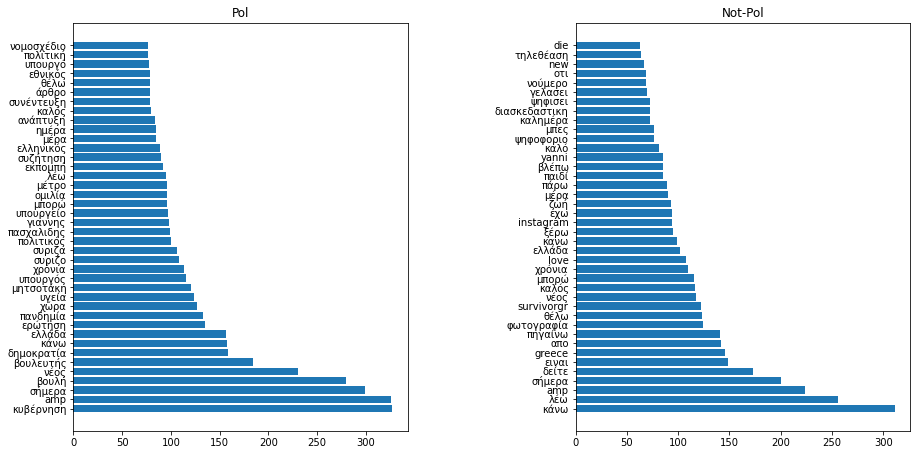

In [43]:
pol_words = pd.Series(' '.join(df_2[df_2.parliament_member == 1].textdata_3).split()).value_counts()
nonpol_words = pd.Series(' '.join(df_2[df_2.parliament_member == 0].textdata_3).split()).value_counts()

fig, axs = plt.subplots(1,2,figsize =(15,7.5))

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5)

axs[0].barh(pol_words[:40].index, pol_words[:40])
axs[0].set_title('Pol')
axs[1].barh(nonpol_words[:40].index, nonpol_words[:40])
axs[1].set_title('Not-Pol')

In [48]:
irr_words = set(['κάνω', 'σήμερα', 'νέος', 'καλός', 'μπορώ', 'amp', 'λέω', 'μέρα', 'ημέρα', 'ελλάδα', 'ελληνικός', 'greece'])

def remove_irrwords(row):
    row = [str(token) for token in nlp_el(row)]
    return [w for w in row if w not in irr_words]

In [49]:
df_2['textdata_1'] = df_2['textdata_1'].apply(lambda row: remove_irrwords(row))
df_2['textdata_1'] = df_2['textdata_1'].apply(lambda row: ' '.join(row))

df_2['textdata_2'] = df_2['textdata_2'].apply(lambda row: remove_irrwords(row))
df_2['textdata_2'] = df_2['textdata_2'].apply(lambda row: ' '.join(row))

df_2['textdata_3'] = df_2['textdata_3'].apply(lambda row: remove_irrwords(row))
df_2['textdata_3'] = df_2['textdata_3'].apply(lambda row: ' '.join(row))

Text(0.5, 1.0, 'Not-Pol')

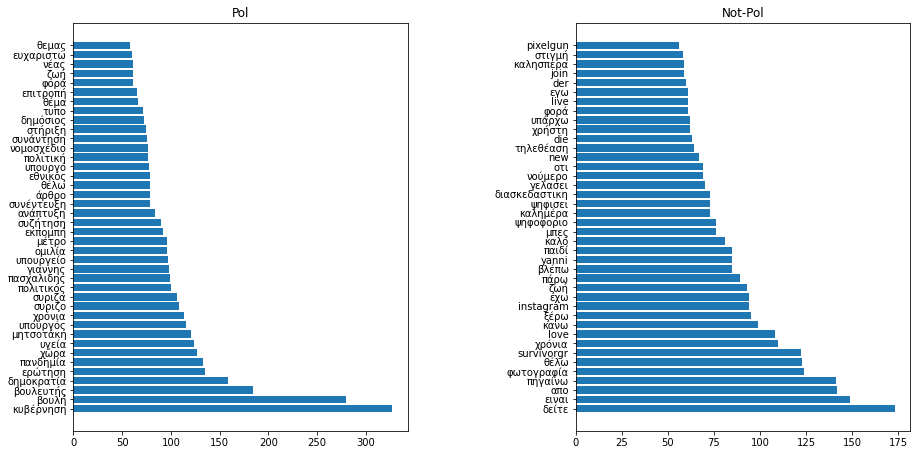

In [50]:
pol_words = pd.Series(' '.join(df_2[df_2.parliament_member == 1].textdata_3).split()).value_counts()
nonpol_words = pd.Series(' '.join(df_2[df_2.parliament_member == 0].textdata_3).split()).value_counts()

fig, axs = plt.subplots(1,2,figsize =(15,7.5))

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5)

axs[0].barh(pol_words[:40].index, pol_words[:40])
axs[0].set_title('Pol')
axs[1].barh(nonpol_words[:40].index, nonpol_words[:40])
axs[1].set_title('Not-Pol')

#### SVM

In [51]:
# TF-IDF 
results = {}
for textdata in tqdm(textdatas):
    print(f'Best params for {textdata}:')
    X = df_2[textdata]
    results[textdata] = classification_svm(X, df_2['parliament_member'], 'TF-IDF').round(4)
    print("============================")
    
svm_tfidf = svm_tfidf.append(
    pd.DataFrame.from_dict(results, orient='index', columns=['Irrelevant Word Removal']).T)

svm_tfidf

  0%|          | 0/3 [00:00<?, ?it/s]

Best params for textdata_1:


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.67333333 0.66       0.65       ...        nan        nan        nan]
  warnings.warn(


{'svm__C': 0.5, 'svm__kernel': 'linear', 'vectorizer__max_df': 0.5, 'vectorizer__max_features': 1000, 'vectorizer__min_df': 1}
Best params for textdata_2:


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.70333333 0.70333333 0.71       ...        nan        nan        nan]
  warnings.warn(


{'svm__C': 5, 'svm__kernel': 'rbf', 'vectorizer__max_df': 0.5, 'vectorizer__max_features': 1000, 'vectorizer__min_df': 1}
Best params for textdata_3:


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.61       0.60666667 0.60666667 ...        nan        nan        nan]
  warnings.warn(


{'svm__C': 1, 'svm__kernel': 'rbf', 'vectorizer__max_df': 0.5, 'vectorizer__max_features': 2000, 'vectorizer__min_df': 5}


,textdata_1,textdata_2,textdata_3
Without NLP,0.8800,0.8800,0.9100
Stopword Removal,0.9000,0.8767,0.9167
Lemmatization,0.9000,0.8733,0.9233
Short Word Removal,0.9033,0.8733,0.9267
Irrelevant Word Removal,0.9100,0.8767,0.9267


In [52]:
# BoW
results = {}
for textdata in tqdm(textdatas):
    print(f'Best params for {textdata}:')
    X = df_2[textdata]
    results[textdata] = classification_svm(X, df_2['parliament_member'], 'BoW').round(4)
    print("============================")
    
svm_bow = svm_bow.append(
    pd.DataFrame.from_dict(results, orient='index', columns=['Irrelevant Word Removal']).T)

svm_bow

  0%|          | 0/3 [00:00<?, ?it/s]

Best params for textdata_1:


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.60666667 0.61       0.61       ...        nan        nan        nan]
  warnings.warn(


{'svm__C': 0.1, 'svm__kernel': 'rbf', 'vectorizer__max_df': 0.5, 'vectorizer__max_features': 10, 'vectorizer__min_df': 5}
Best params for textdata_2:


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.62666667 0.62666667 0.60333333 ...        nan        nan        nan]
  warnings.warn(


{'svm__C': 0.5, 'svm__kernel': 'linear', 'vectorizer__max_df': 0.5, 'vectorizer__max_features': 2000, 'vectorizer__min_df': 1}
Best params for textdata_3:


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.51666667 0.51333333 0.51333333 ...        nan        nan        nan]
  warnings.warn(


{'svm__C': 1, 'svm__kernel': 'linear', 'vectorizer__max_df': 0.5, 'vectorizer__max_features': None, 'vectorizer__min_df': 1}


,textdata_1,textdata_2,textdata_3
Without NLP,0.8767,0.8667,0.8633
Stopword Removal,0.8967,0.8967,0.8933
Lemmatization,0.8900,0.8667,0.8867
Short Word Removal,0.8967,0.8600,0.8767
Irrelevant Word Removal,0.8967,0.8700,0.8700


#### Logistic Regression

In [53]:
# TF-IDF 
results = {}
for textdata in tqdm(textdatas):
    print(f'Best params for {textdata}:')
    X = df_2[textdata]
    results[textdata] = classification_lr(X, df_2['parliament_member'], 'TF-IDF').round(4)
    print("============================")
    
lr_tfidf = lr_tfidf.append(
    pd.DataFrame.from_dict(results, orient='index', columns=['Irrelevant Word Removal']).T)

lr_tfidf

  0%|          | 0/3 [00:00<?, ?it/s]

Best params for textdata_1:


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [nan nan nan ... nan nan nan]
  warnings.warn(


{'lr__C': 0.1, 'lr__penalty': 'l2', 'vectorizer__max_df': 0.5, 'vectorizer__max_features': 2000, 'vectorizer__min_df': 1}
Best params for textdata_2:


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [nan nan nan ... nan nan nan]
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


{'lr__C': 0.1, 'lr__penalty': 'none', 'vectorizer__max_df': 0.5, 'vectorizer__max_features': 1000, 'vectorizer__min_df': 1}
Best params for textdata_3:


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [nan nan nan ... nan nan nan]
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


{'lr__C': 0.1, 'lr__penalty': 'none', 'vectorizer__max_df': 0.5, 'vectorizer__max_features': 2000, 'vectorizer__min_df': 1}


,textdata_1,textdata_2,textdata_3
Without NLP,0.8700,0.8733,0.9000
Stopword Removal,0.9100,0.8733,0.9133
Lemmatization,0.9067,0.8800,0.9267
Short Word Removal,0.9067,0.8767,0.9200
Irrelevant Word Removal,0.9067,0.8833,0.9200


In [54]:
# BoW
results = {}
for textdata in tqdm(textdatas):
    print(f'Best params for {textdata}:')
    X = df_2[textdata]
    results[textdata] = classification_lr(X, df_2['parliament_member'], 'BoW').round(4)
    print("============================")
    
lr_bow = lr_bow.append(
    pd.DataFrame.from_dict(results, orient='index', columns=['Irrelevant Word Removal']).T)

lr_bow

  0%|          | 0/3 [00:00<?, ?it/s]

Best params for textdata_1:


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [nan nan nan ... nan nan nan]
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


{'lr__C': 0.1, 'lr__penalty': 'none', 'vectorizer__max_df': 0.5, 'vectorizer__max_features': 10, 'vectorizer__min_df': 5}
Best params for textdata_2:


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [nan nan nan ... nan nan nan]
  warnings.warn(


{'lr__C': 10, 'lr__penalty': 'l2', 'vectorizer__max_df': 0.5, 'vectorizer__max_features': 2000, 'vectorizer__min_df': 1}
Best params for textdata_3:


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [nan nan nan ... nan nan nan]
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


{'lr__C': 0.1, 'lr__penalty': 'none', 'vectorizer__max_df': 0.5, 'vectorizer__max_features': None, 'vectorizer__min_df': 1}


,textdata_1,textdata_2,textdata_3
Without NLP,0.8867,0.8767,0.8867
Stopword Removal,0.9000,0.8767,0.9133
Lemmatization,0.8900,0.8800,0.9100
Short Word Removal,0.8900,0.8800,0.9033
Irrelevant Word Removal,0.8900,0.8900,0.9100


#### kNN

In [55]:
# TF-IDF 
results = {}
for textdata in tqdm(textdatas):
    print(f'Best params for {textdata}:')
    X = df_2[textdata]
    results[textdata] = classification_knn(X, df_2['parliament_member'], 'TF-IDF').round(4)
    print("============================")
    
knn_tfidf = knn_tfidf.append(
    pd.DataFrame.from_dict(results, orient='index', columns=['Irrelevant Word Removal']).T)

knn_tfidf

  0%|          | 0/3 [00:00<?, ?it/s]

Best params for textdata_1:


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.74333333 0.74666667 0.71666667 ...        nan        nan        nan]
  warnings.warn(


{'knn__n_neighbors': 7, 'knn__weights': 'uniform', 'vectorizer__max_df': 0.5, 'vectorizer__max_features': 10, 'vectorizer__min_df': 5}
Best params for textdata_2:


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.64333333 0.64666667 0.65       ...        nan        nan        nan]
  warnings.warn(


{'knn__n_neighbors': 10, 'knn__weights': 'uniform', 'vectorizer__max_df': 0.5, 'vectorizer__max_features': None, 'vectorizer__min_df': 1}
Best params for textdata_3:


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.64       0.64333333 0.64333333 ...        nan        nan        nan]
  warnings.warn(


{'knn__n_neighbors': 4, 'knn__weights': 'uniform', 'vectorizer__max_df': 0.25, 'vectorizer__max_features': None, 'vectorizer__min_df': 1}


,textdata_1,textdata_2,textdata_3
Without NLP,0.8567,0.8333,0.8767
Stopword Removal,0.8867,0.8467,0.8933
Lemmatization,0.8900,0.8233,0.9133
Short Word Removal,0.8967,0.8267,0.9033
Irrelevant Word Removal,0.8967,0.8667,0.8933


In [56]:
# BoW
results = {}
for textdata in tqdm(textdatas):
    print(f'Best params for {textdata}:')
    X = df_2[textdata]
    results[textdata] = classification_knn(X, df_2['parliament_member'], 'BoW').round(4)
    print("============================")
    
knn_bow = knn_bow.append(
    pd.DataFrame.from_dict(results, orient='index', columns=['Irrelevant Word Removal']).T)

knn_bow

  0%|          | 0/3 [00:00<?, ?it/s]

Best params for textdata_1:


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.74       0.74333333 0.71       ...        nan        nan        nan]
  warnings.warn(


{'knn__n_neighbors': 3, 'knn__weights': 'distance', 'vectorizer__max_df': 0.5, 'vectorizer__max_features': 10, 'vectorizer__min_df': 5}
Best params for textdata_2:


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.61666667 0.62       0.62333333 ...        nan        nan        nan]
  warnings.warn(


{'knn__n_neighbors': 5, 'knn__weights': 'distance', 'vectorizer__max_df': 0.5, 'vectorizer__max_features': 10, 'vectorizer__min_df': 10}
Best params for textdata_3:


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.64333333 0.64666667 0.64666667 ...        nan        nan        nan]
  warnings.warn(


{'knn__n_neighbors': 10, 'knn__weights': 'distance', 'vectorizer__max_df': 0.5, 'vectorizer__max_features': 100, 'vectorizer__min_df': 10}


,textdata_1,textdata_2,textdata_3
Without NLP,0.8467,0.7933,0.8500
Stopword Removal,0.8767,0.8233,0.8533
Lemmatization,0.8600,0.7933,0.8433
Short Word Removal,0.8900,0.8267,0.8533
Irrelevant Word Removal,0.8900,0.8533,0.8633


### Export Model
- TF-IDF outperformed BoW with in every case.
- Highest Accuracy was achieved using recent 100 tweets
- Support Vector Machine and Logistic Regression have a better performance.
- Logistic Regression Reached the highest achieved accuracy with less NLP steps than Support Vector Machines

The best models we found are: Logistic Regression-TF-IDF and Support Vector Machines - TF-IDF.
We chose logistic regression as is required less preprocessing steps.

- vectorizer__max_df: 0.75
- vectorizer__max_features: None
- vectorizer__min_df: 1
- lr__penalty: None<br>

with the following NLP steps:
- Lemmatization
- Stop Word Removal

In [24]:
def get_text_data_ndt(df):
    df['textdata'] = clean_text(df['name'] + ' ' + df['description'] + ' ' + df['recent_100_tweets'])
    df['textdata'] = df['textdata'].apply(lambda row: tokenize_lemmatize(row))
    df['textdata'] = df['textdata'].apply(lambda row: ' '.join(row))
    df['textdata'] = df['textdata'].apply(lambda row: remove_stopwords(row))
    df['textdata'] = df['textdata'].apply(lambda row: ' '.join(row))
    return df.textdata


get_text_ndt = FunctionTransformer(get_text_data_ndt)

In [25]:
pipeline = Pipeline([
    ('selector_ndt', get_text_ndt),
    ('tfidf', TfidfVectorizer(max_df=0.75, max_features=None, min_df=1)),
    ('lr', LogisticRegression(max_iter=1000, penalty = 'none'))
])

In [28]:
X = training_set
y = training_set.parliament_member
pipeline.fit(X,y)

Pipeline(steps=[('selector_ndt',
                 FunctionTransformer(func=<function get_text_data_ndt at 0x7fb53942a550>)),
                ('tfidf', TfidfVectorizer(max_df=0.75)),
                ('lr', LogisticRegression(max_iter=1000, penalty='none'))])

In [29]:
filename = '../classifiers/classifier_politician_ndt.sav'
joblib.dump(pipeline, filename)

['../classifiers/classifier_politician_ndt.sav']

# Case 2: Tweets Only
---
In this case we fetch 100 tweets if possible for each node, and try to classify them using only their tweets.

## Text Normalization

In [64]:
data = training_set.copy()
data = data.drop(['name', 'description', 'statuses_count', 'recent_tweet', 'recent_10_tweets'], axis = 1)
data.head(3)

,screen_name,parliament_member,recent_100_tweets
0,evefthym,0,#NewProfilePic https://t.co/h0wlMIS6U0 @wavyp...
1,Qdv6zNFe0nkBH2m,0,
2,michail_pana,0,@odyssefs357 Γιατί έτσι όπως έγινε δεν παίρνε...


We normalize our text by taking the following actions:

- remove URLs
- remove anything that isn't a unicode character (e.g emojis, punctuation)
- remove numbers and _
- fix whitespace
- convert to lower case

In [65]:
data['recent_100_tweets'] = clean_text(data['recent_100_tweets'])

## Model Selection

In [66]:
textdatas = ['recent_100_tweets']

In [67]:
svm_tfidf = pd.DataFrame()
svm_bow = pd.DataFrame()

lr_tfidf = pd.DataFrame()
lr_bow = pd.DataFrame()

knn_tfidf = pd.DataFrame()
knn_bow = pd.DataFrame()

#### SVM

In [68]:
# TF-IDF 
results = {}
for textdata in tqdm(textdatas):
    print(f'Best params for {textdata}:')
    X = data[textdata]
    results[textdata] = classification_svm(X, data['parliament_member'], 'TF-IDF').round(4)
    print("============================")
    
svm_tfidf = svm_tfidf.append(
    pd.DataFrame.from_dict(results, orient='index', columns=['Without NLP']).T)

svm_tfidf

  0%|          | 0/1 [00:00<?, ?it/s]

Best params for recent_100_tweets:


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.61333333 0.61333333 0.61333333 ...        nan        nan        nan]
  warnings.warn(


{'svm__C': 1, 'svm__kernel': 'rbf', 'vectorizer__max_df': 0.5, 'vectorizer__max_features': 1000, 'vectorizer__min_df': 1}


,recent_100_tweets
Without NLP,0.86


In [69]:
# BoW
results = {}
for textdata in tqdm(textdatas):
    print(f'Best params for {textdata}:')
    X = data[textdata]
    results[textdata] = classification_svm(X, data['parliament_member'], 'BoW').round(4)
    print("============================")
    
svm_bow = svm_bow.append(
    pd.DataFrame.from_dict(results, orient='index', columns=['Without NLP']).T)

svm_bow

  0%|          | 0/1 [00:00<?, ?it/s]

Best params for recent_100_tweets:


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.63 0.63 0.63 ...  nan  nan  nan]
  warnings.warn(


{'svm__C': 10, 'svm__kernel': 'linear', 'vectorizer__max_df': 0.75, 'vectorizer__max_features': 100, 'vectorizer__min_df': 10}


,recent_100_tweets
Without NLP,0.7833


#### Logistic Regression

In [70]:
# TF-IDF 
results = {}
for textdata in tqdm(textdatas):
    print(f'Best params for {textdata}:')
    X = data[textdata]
    results[textdata] = classification_lr(X, data['parliament_member'], 'TF-IDF').round(4)
    print("============================")
    
lr_tfidf = lr_tfidf.append(
    pd.DataFrame.from_dict(results, orient='index', columns=['Without NLP']).T)

lr_tfidf

  0%|          | 0/1 [00:00<?, ?it/s]

Best params for recent_100_tweets:


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [nan nan nan ... nan nan nan]
  warnings.warn(


{'lr__C': 0.1, 'lr__penalty': 'none', 'vectorizer__max_df': 0.25, 'vectorizer__max_features': 2000, 'vectorizer__min_df': 5}


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


,recent_100_tweets
Without NLP,0.8633


In [71]:
# BoW
results = {}
for textdata in tqdm(textdatas):
    print(f'Best params for {textdata}:')
    X = data[textdata]
    results[textdata] = classification_lr(X, data['parliament_member'], 'BoW').round(4)
    print("============================")
    
lr_bow = lr_bow.append(
    pd.DataFrame.from_dict(results, orient='index', columns=['Without NLP']).T)

lr_bow

  0%|          | 0/1 [00:00<?, ?it/s]

Best params for recent_100_tweets:


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [nan nan nan ... nan nan nan]
  warnings.warn(


{'lr__C': 0.1, 'lr__penalty': 'none', 'vectorizer__max_df': 0.5, 'vectorizer__max_features': 1000, 'vectorizer__min_df': 5}


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


,recent_100_tweets
Without NLP,0.8467


#### kNN

In [72]:
# TF-IDF 
results = {}
for textdata in tqdm(textdatas):
    print(f'Best params for {textdata}:')
    X = data[textdata]
    results[textdata] = classification_knn(X, data['parliament_member'], 'TF-IDF').round(4)
    print("============================")
    
knn_tfidf = knn_tfidf.append(
    pd.DataFrame.from_dict(results, orient='index', columns=['Without NLP']).T)

knn_tfidf

  0%|          | 0/1 [00:00<?, ?it/s]

Best params for recent_100_tweets:


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.55 0.55 0.55 ...  nan  nan  nan]
  warnings.warn(


{'knn__n_neighbors': 4, 'knn__weights': 'distance', 'vectorizer__max_df': 0.5, 'vectorizer__max_features': 100, 'vectorizer__min_df': 1}


,recent_100_tweets
Without NLP,0.84


In [73]:
# BoW
results = {}
for textdata in tqdm(textdatas):
    print(f'Best params for {textdata}:')
    X = data[textdata]
    results[textdata] = classification_knn(X, data['parliament_member'], 'BoW').round(4)
    print("============================")
    
knn_bow = knn_bow.append(
    pd.DataFrame.from_dict(results, orient='index', columns=['Without NLP']).T)

knn_bow

  0%|          | 0/1 [00:00<?, ?it/s]

Best params for recent_100_tweets:


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.55       0.55       0.55333333 ...        nan        nan        nan]
  warnings.warn(


{'knn__n_neighbors': 5, 'knn__weights': 'distance', 'vectorizer__max_df': 0.75, 'vectorizer__max_features': 10, 'vectorizer__min_df': 1}


,recent_100_tweets
Without NLP,0.7967


### Stop Word Removal

In [74]:
nlp_el = spacy.load('el_core_news_md')
nlp_en = spacy.load('en_core_web_sm')
STOPWORDS = set(list(spacy.lang.en.STOP_WORDS) + list(spacy.lang.el.STOP_WORDS))

def remove_stopwords(row):
    row = [str(token) for token in nlp_el(row)]
    return [w for w in row if w not in STOPWORDS]

In [75]:
df = data.copy()

df['recent_100_tweets'] = df['recent_100_tweets'].apply(lambda row: remove_stopwords(row))
df['recent_100_tweets'] = df['recent_100_tweets'].apply(lambda row: ' '.join(row))


#### SVM

In [76]:
# TF-IDF 
results = {}
for textdata in tqdm(textdatas):
    print(f'Best params for {textdata}:')
    X = df[textdata]
    results[textdata] = classification_svm(X, df['parliament_member'], 'TF-IDF').round(4)
    print("============================")
    
svm_tfidf = svm_tfidf.append(
    pd.DataFrame.from_dict(results, orient='index', columns=['Stopword Removal']).T)

svm_tfidf

  0%|          | 0/1 [00:00<?, ?it/s]

Best params for recent_100_tweets:


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.57       0.57       0.64333333 ...        nan        nan        nan]
  warnings.warn(


{'svm__C': 5, 'svm__kernel': 'rbf', 'vectorizer__max_df': 0.75, 'vectorizer__max_features': 1000, 'vectorizer__min_df': 1}


,recent_100_tweets
Without NLP,0.86
Stopword Removal,0.84


In [77]:
# BoW
results = {}
for textdata in tqdm(textdatas):
    print(f'Best params for {textdata}:')
    X = df[textdata]
    results[textdata] = classification_svm(X, df['parliament_member'], 'BoW').round(4)
    print("============================")
    
svm_bow = svm_bow.append(
    pd.DataFrame.from_dict(results, orient='index', columns=['Stopword Removal']).T)

svm_bow

  0%|          | 0/1 [00:00<?, ?it/s]

Best params for recent_100_tweets:


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.56666667 0.56666667 0.56333333 ...        nan        nan        nan]
  warnings.warn(


{'svm__C': 10, 'svm__kernel': 'linear', 'vectorizer__max_df': 0.75, 'vectorizer__max_features': 100, 'vectorizer__min_df': 25}


,recent_100_tweets
Without NLP,0.7833
Stopword Removal,0.7833


#### Logistic Regression

In [78]:
# TF-IDF 
results = {}
for textdata in tqdm(textdatas):
    print(f'Best params for {textdata}:')
    X = df[textdata]
    results[textdata] = classification_lr(X, df['parliament_member'], 'TF-IDF').round(4)
    print("============================")
    
lr_tfidf = lr_tfidf.append(
    pd.DataFrame.from_dict(results, orient='index', columns=['Stopword Removal']).T)

lr_tfidf

  0%|          | 0/1 [00:00<?, ?it/s]

Best params for recent_100_tweets:


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [nan nan nan ... nan nan nan]
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


{'lr__C': 0.1, 'lr__penalty': 'none', 'vectorizer__max_df': 0.75, 'vectorizer__max_features': None, 'vectorizer__min_df': 5}


,recent_100_tweets
Without NLP,0.8633
Stopword Removal,0.8833


In [79]:
# BoW
results = {}
for textdata in tqdm(textdatas):
    print(f'Best params for {textdata}:')
    X = df[textdata]
    results[textdata] = classification_lr(X, df['parliament_member'], 'BoW').round(4)
    print("============================")
    
lr_bow = lr_bow.append(
    pd.DataFrame.from_dict(results, orient='index', columns=['Stopword Removal']).T)

lr_bow

  0%|          | 0/1 [00:00<?, ?it/s]

Best params for recent_100_tweets:


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [nan nan nan ... nan nan nan]
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


{'lr__C': 0.1, 'lr__penalty': 'none', 'vectorizer__max_df': 0.75, 'vectorizer__max_features': None, 'vectorizer__min_df': 5}


,recent_100_tweets
Without NLP,0.8467
Stopword Removal,0.8833


#### kNN

In [80]:
# TF-IDF 
results = {}
for textdata in tqdm(textdatas):
    print(f'Best params for {textdata}:')
    X = df[textdata]
    results[textdata] = classification_knn(X, df['parliament_member'], 'TF-IDF').round(4)
    print("============================")
    
knn_tfidf = knn_tfidf.append(
    pd.DataFrame.from_dict(results, orient='index', columns=['Stopword Removal']).T)

knn_tfidf

  0%|          | 0/1 [00:00<?, ?it/s]

Best params for recent_100_tweets:


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.58333333 0.58333333 0.59       ...        nan        nan        nan]
  warnings.warn(


{'knn__n_neighbors': 6, 'knn__weights': 'uniform', 'vectorizer__max_df': 0.75, 'vectorizer__max_features': 100, 'vectorizer__min_df': 25}


,recent_100_tweets
Without NLP,0.8400
Stopword Removal,0.8033


In [81]:
# BoW
results = {}
for textdata in tqdm(textdatas):
    print(f'Best params for {textdata}:')
    X = df[textdata]
    results[textdata] = classification_knn(X, df['parliament_member'], 'BoW').round(4)
    print("============================")
    
knn_bow = knn_bow.append(
    pd.DataFrame.from_dict(results, orient='index', columns=['Stopword Removal']).T)

knn_bow

  0%|          | 0/1 [00:00<?, ?it/s]

Best params for recent_100_tweets:


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.58666667 0.58666667 0.59666667 ...        nan        nan        nan]
  warnings.warn(


{'knn__n_neighbors': 4, 'knn__weights': 'distance', 'vectorizer__max_df': 0.25, 'vectorizer__max_features': 10, 'vectorizer__min_df': 25}


,recent_100_tweets
Without NLP,0.7967
Stopword Removal,0.7400


### Lemmatization

In [82]:
def tokenize_lemmatize(row):
    return [str(token.lemma_) for token in nlp_el(row)]

In [83]:
df = data.copy()

df['recent_100_tweets'] = df['recent_100_tweets'].apply(lambda row: tokenize_lemmatize(row))
df['recent_100_tweets'] = df['recent_100_tweets'].apply(lambda row: ' '.join(row))
df['recent_100_tweets'] = df['recent_100_tweets'].apply(lambda row: remove_stopwords(row))
df['recent_100_tweets'] = df['recent_100_tweets'].apply(lambda row: ' '.join(row))

#### SVM

In [84]:
# TF-IDF 
results = {}
for textdata in tqdm(textdatas):
    print(f'Best params for {textdata}:')
    X = df[textdata]
    results[textdata] = classification_svm(X, df['parliament_member'], 'TF-IDF').round(4)
    print("============================")
    
svm_tfidf = svm_tfidf.append(
    pd.DataFrame.from_dict(results, orient='index', columns=['Lemmatization']).T)

svm_tfidf

  0%|          | 0/1 [00:00<?, ?it/s]

Best params for recent_100_tweets:


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.59       0.59       0.60333333 ...        nan        nan        nan]
  warnings.warn(


{'svm__C': 5, 'svm__kernel': 'rbf', 'vectorizer__max_df': 0.75, 'vectorizer__max_features': 1000, 'vectorizer__min_df': 10}


,recent_100_tweets
Without NLP,0.8600
Stopword Removal,0.8400
Lemmatization,0.8433


In [85]:
# BoW
results = {}
for textdata in tqdm(textdatas):
    print(f'Best params for {textdata}:')
    X = df[textdata]
    results[textdata] = classification_svm(X, df['parliament_member'], 'BoW').round(4)
    print("============================")
    
svm_bow = svm_bow.append(
    pd.DataFrame.from_dict(results, orient='index', columns=['Lemmatization']).T)

svm_bow

  0%|          | 0/1 [00:00<?, ?it/s]

Best params for recent_100_tweets:


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.52666667 0.52666667 0.53333333 ...        nan        nan        nan]
  warnings.warn(


{'svm__C': 1, 'svm__kernel': 'linear', 'vectorizer__max_df': 0.5, 'vectorizer__max_features': 1000, 'vectorizer__min_df': 10}


,recent_100_tweets
Without NLP,0.7833
Stopword Removal,0.7833
Lemmatization,0.7767


#### Logistic Regression

In [86]:
# TF-IDF 
results = {}
for textdata in tqdm(textdatas):
    print(f'Best params for {textdata}:')
    X = df[textdata]
    results[textdata] = classification_lr(X, df['parliament_member'], 'TF-IDF').round(4)
    print("============================")
    
lr_tfidf = lr_tfidf.append(
    pd.DataFrame.from_dict(results, orient='index', columns=['Lemmatization']).T)

lr_tfidf

  0%|          | 0/1 [00:00<?, ?it/s]

Best params for recent_100_tweets:


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [nan nan nan ... nan nan nan]
  warnings.warn(


{'lr__C': 0.1, 'lr__penalty': 'none', 'vectorizer__max_df': 0.5, 'vectorizer__max_features': 1000, 'vectorizer__min_df': 5}


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


,recent_100_tweets
Without NLP,0.8633
Stopword Removal,0.8833
Lemmatization,0.8767


In [87]:
# BoW
results = {}
for textdata in tqdm(textdatas):
    print(f'Best params for {textdata}:')
    X = df[textdata]
    results[textdata] = classification_lr(X, df['parliament_member'], 'BoW').round(4)
    print("============================")
    
lr_bow = lr_bow.append(
    pd.DataFrame.from_dict(results, orient='index', columns=['Lemmatization']).T)

lr_bow

  0%|          | 0/1 [00:00<?, ?it/s]

Best params for recent_100_tweets:


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [nan nan nan ... nan nan nan]
  warnings.warn(


{'lr__C': 0.1, 'lr__penalty': 'none', 'vectorizer__max_df': 0.5, 'vectorizer__max_features': 2000, 'vectorizer__min_df': 5}


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


,recent_100_tweets
Without NLP,0.8467
Stopword Removal,0.8833
Lemmatization,0.8633


#### kNN

In [88]:
# TF-IDF 
results = {}
for textdata in tqdm(textdatas):
    print(f'Best params for {textdata}:')
    X = df[textdata]
    results[textdata] = classification_knn(X, df['parliament_member'], 'TF-IDF').round(4)
    print("============================")
    
knn_tfidf = knn_tfidf.append(
    pd.DataFrame.from_dict(results, orient='index', columns=['Lemmatization']).T)

knn_tfidf

  0%|          | 0/1 [00:00<?, ?it/s]

Best params for recent_100_tweets:


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.61       0.61       0.60333333 ...        nan        nan        nan]
  warnings.warn(


{'knn__n_neighbors': 4, 'knn__weights': 'uniform', 'vectorizer__max_df': 0.75, 'vectorizer__max_features': 100, 'vectorizer__min_df': 5}


,recent_100_tweets
Without NLP,0.8400
Stopword Removal,0.8033
Lemmatization,0.8200


In [89]:
# BoW
results = {}
for textdata in tqdm(textdatas):
    print(f'Best params for {textdata}:')
    X = df[textdata]
    results[textdata] = classification_knn(X, df['parliament_member'], 'BoW').round(4)
    print("============================")
    
knn_bow = knn_bow.append(
    pd.DataFrame.from_dict(results, orient='index', columns=['Lemmatization']).T)
knn_bow

  0%|          | 0/1 [00:00<?, ?it/s]

Best params for recent_100_tweets:


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.58333333 0.58333333 0.59333333 ...        nan        nan        nan]
  warnings.warn(


{'knn__n_neighbors': 4, 'knn__weights': 'distance', 'vectorizer__max_df': 0.25, 'vectorizer__max_features': 10, 'vectorizer__min_df': 25}


,recent_100_tweets
Without NLP,0.7967
Stopword Removal,0.7400
Lemmatization,0.7400


### Short Word Removal

In [90]:
df_2 = df.copy()

In [91]:
def remove_shortwords(row):
    row = [str(token) for token in nlp_el(row)]
    return [w for w in row if len(w) > 2]

In [92]:
df_2['recent_100_tweets'] = df_2['recent_100_tweets'].apply(lambda row: remove_shortwords(row))
df_2['recent_100_tweets'] = df_2['recent_100_tweets'].apply(lambda row: ' '.join(row))

#### SVM

In [93]:
# TF-IDF 
results = {}
for textdata in tqdm(textdatas):
    print(f'Best params for {textdata}:')
    X = df_2[textdata]
    results[textdata] = classification_svm(X, df_2['parliament_member'], 'TF-IDF').round(4)
    print("============================")
    
svm_tfidf = svm_tfidf.append(
    pd.DataFrame.from_dict(results, orient='index', columns=['Short Word Removal']).T)

svm_tfidf

  0%|          | 0/1 [00:00<?, ?it/s]

Best params for recent_100_tweets:


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.60333333 0.60333333 0.60666667 ...        nan        nan        nan]
  warnings.warn(


{'svm__C': 1, 'svm__kernel': 'sigmoid', 'vectorizer__max_df': 0.25, 'vectorizer__max_features': 2000, 'vectorizer__min_df': 1}


,recent_100_tweets
Without NLP,0.8600
Stopword Removal,0.8400
Lemmatization,0.8433
Short Word Removal,0.8333


In [94]:
# BoW
results = {}
for textdata in tqdm(textdatas):
    print(f'Best params for {textdata}:')
    X = df_2[textdata]
    results[textdata] = classification_svm(X, df_2['parliament_member'], 'BoW').round(4)
    print("============================")
    
svm_bow = svm_bow.append(
    pd.DataFrame.from_dict(results, orient='index', columns=['Short Word Removal']).T)

svm_bow

  0%|          | 0/1 [00:00<?, ?it/s]

Best params for recent_100_tweets:


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.55       0.55       0.54666667 ...        nan        nan        nan]
  warnings.warn(


{'svm__C': 0.1, 'svm__kernel': 'sigmoid', 'vectorizer__max_df': 1, 'vectorizer__max_features': None, 'vectorizer__min_df': 1}


,recent_100_tweets
Without NLP,0.7833
Stopword Removal,0.7833
Lemmatization,0.7767
Short Word Removal,0.7733


#### Logistic Regression

In [95]:
# TF-IDF 
results = {}
for textdata in tqdm(textdatas):
    print(f'Best params for {textdata}:')
    X = df_2[textdata]
    results[textdata] = classification_lr(X, df_2['parliament_member'], 'TF-IDF').round(4)
    print("============================")
    
lr_tfidf = lr_tfidf.append(
    pd.DataFrame.from_dict(results, orient='index', columns=['Short Word Removal']).T)

lr_tfidf

  0%|          | 0/1 [00:00<?, ?it/s]

Best params for recent_100_tweets:


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [nan nan nan ... nan nan nan]
  warnings.warn(


{'lr__C': 0.1, 'lr__penalty': 'none', 'vectorizer__max_df': 0.25, 'vectorizer__max_features': 2000, 'vectorizer__min_df': 5}


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


,recent_100_tweets
Without NLP,0.8633
Stopword Removal,0.8833
Lemmatization,0.8767
Short Word Removal,0.8667


In [96]:
# BoW
results = {}
for textdata in tqdm(textdatas):
    print(f'Best params for {textdata}:')
    X = df_2[textdata]
    results[textdata] = classification_lr(X, df_2['parliament_member'], 'BoW').round(4)
    print("============================")
    
lr_bow = lr_bow.append(
    pd.DataFrame.from_dict(results, orient='index', columns=['Short Word Removal']).T)

lr_bow

  0%|          | 0/1 [00:00<?, ?it/s]

Best params for recent_100_tweets:


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [nan nan nan ... nan nan nan]
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


{'lr__C': 0.1, 'lr__penalty': 'none', 'vectorizer__max_df': 0.5, 'vectorizer__max_features': None, 'vectorizer__min_df': 5}


,recent_100_tweets
Without NLP,0.8467
Stopword Removal,0.8833
Lemmatization,0.8633
Short Word Removal,0.8567


#### kNN

In [97]:
# TF-IDF 
results = {}
for textdata in tqdm(textdatas):
    print(f'Best params for {textdata}:')
    X = df_2[textdata]
    results[textdata] = classification_knn(X, df_2['parliament_member'], 'TF-IDF').round(4)
    print("============================")
    
knn_tfidf = knn_tfidf.append(
    pd.DataFrame.from_dict(results, orient='index', columns=['Short Word Removal']).T)

knn_tfidf

  0%|          | 0/1 [00:00<?, ?it/s]

Best params for recent_100_tweets:


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.61333333 0.61333333 0.61       ...        nan        nan        nan]
  warnings.warn(


{'knn__n_neighbors': 5, 'knn__weights': 'distance', 'vectorizer__max_df': 0.25, 'vectorizer__max_features': 100, 'vectorizer__min_df': 1}


,recent_100_tweets
Without NLP,0.8400
Stopword Removal,0.8033
Lemmatization,0.8200
Short Word Removal,0.7767


In [98]:
# BoW
results = {}
for textdata in tqdm(textdatas):
    print(f'Best params for {textdata}:')
    X = df_2[textdata]
    results[textdata] = classification_knn(X, df_2['parliament_member'], 'BoW').round(4)
    print("============================")
    
knn_bow = knn_bow.append(
    pd.DataFrame.from_dict(results, orient='index', columns=['Short Word Removal']).T)

knn_bow

  0%|          | 0/1 [00:00<?, ?it/s]

Best params for recent_100_tweets:


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.58666667 0.58666667 0.60333333 ...        nan        nan        nan]
  warnings.warn(


{'knn__n_neighbors': 9, 'knn__weights': 'distance', 'vectorizer__max_df': 0.5, 'vectorizer__max_features': 10, 'vectorizer__min_df': 10}


,recent_100_tweets
Without NLP,0.7967
Stopword Removal,0.7400
Lemmatization,0.7400
Short Word Removal,0.7567


### Irrelevant Word Removal

Text(0.5, 1.0, 'Not-Pol')

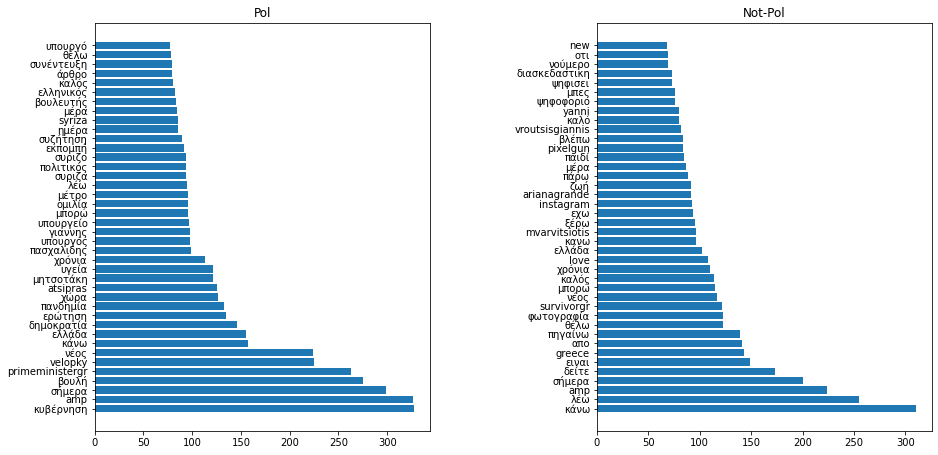

In [100]:
pol_words = pd.Series(' '.join(df_2[df_2.parliament_member == 1].recent_100_tweets).split()).value_counts()
nonpol_words = pd.Series(' '.join(df_2[df_2.parliament_member == 0].recent_100_tweets).split()).value_counts()

fig, axs = plt.subplots(1,2,figsize =(15,7.5))

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5)

axs[0].barh(pol_words[:40].index, pol_words[:40])
axs[0].set_title('Pol')
axs[1].barh(nonpol_words[:40].index, nonpol_words[:40])
axs[1].set_title('Not-Pol')

In [101]:
irr_words = set(['κάνω', 'σήμερα', 'νέος', 'καλός', 'μπορώ', 'amp', 'λέω', 'μέρα', 'ημέρα', 'ελλάδα', 'ελληνικός', 'greece'])

def remove_irrwords(row):
    row = [str(token) for token in nlp_el(row)]
    return [w for w in row if w not in irr_words]

In [105]:
df_2['recent_100_tweets'] = df_2['recent_100_tweets'].apply(lambda row: remove_irrwords(row))
df_2['recent_100_tweets'] = df_2['recent_100_tweets'].apply(lambda row: ' '.join(row))


Text(0.5, 1.0, 'Not-Pol')

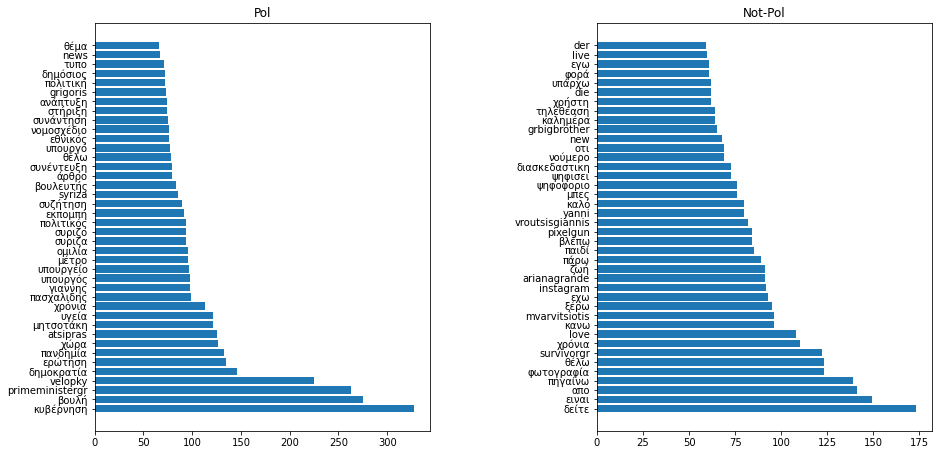

In [106]:
pol_words = pd.Series(' '.join(df_2[df_2.parliament_member == 1].recent_100_tweets).split()).value_counts()
nonpol_words = pd.Series(' '.join(df_2[df_2.parliament_member == 0].recent_100_tweets).split()).value_counts()

fig, axs = plt.subplots(1,2,figsize =(15,7.5))

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5)

axs[0].barh(pol_words[:40].index, pol_words[:40])
axs[0].set_title('Pol')
axs[1].barh(nonpol_words[:40].index, nonpol_words[:40])
axs[1].set_title('Not-Pol')

#### SVM

In [107]:
# TF-IDF 
results = {}
for textdata in tqdm(textdatas):
    print(f'Best params for {textdata}:')
    X = df_2[textdata]
    results[textdata] = classification_svm(X, df_2['parliament_member'], 'TF-IDF').round(4)
    print("============================")
    
svm_tfidf = svm_tfidf.append(
    pd.DataFrame.from_dict(results, orient='index', columns=['Irrelevant Word Removal']).T)

svm_tfidf

  0%|          | 0/1 [00:00<?, ?it/s]

Best params for recent_100_tweets:


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.67 0.67 0.66 ...  nan  nan  nan]
  warnings.warn(


{'svm__C': 1, 'svm__kernel': 'sigmoid', 'vectorizer__max_df': 0.5, 'vectorizer__max_features': 2000, 'vectorizer__min_df': 1}


,recent_100_tweets
Without NLP,0.8600
Stopword Removal,0.8400
Lemmatization,0.8433
Short Word Removal,0.8333
Irrelevant Word Removal,0.8367


In [108]:
# BoW
results = {}
for textdata in tqdm(textdatas):
    print(f'Best params for {textdata}:')
    X = df_2[textdata]
    results[textdata] = classification_svm(X, df_2['parliament_member'], 'BoW').round(4)
    print("============================")
    
svm_bow = svm_bow.append(
    pd.DataFrame.from_dict(results, orient='index', columns=['Irrelevant Word Removal']).T)

svm_bow

  0%|          | 0/1 [00:00<?, ?it/s]

Best params for recent_100_tweets:


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.53666667 0.53666667 0.52666667 ...        nan        nan        nan]
  warnings.warn(


{'svm__C': 0.1, 'svm__kernel': 'sigmoid', 'vectorizer__max_df': 1, 'vectorizer__max_features': None, 'vectorizer__min_df': 1}


,recent_100_tweets
Without NLP,0.7833
Stopword Removal,0.7833
Lemmatization,0.7767
Short Word Removal,0.7733
Irrelevant Word Removal,0.7733


#### Logistic Regression

In [109]:
# TF-IDF 
results = {}
for textdata in tqdm(textdatas):
    print(f'Best params for {textdata}:')
    X = df_2[textdata]
    results[textdata] = classification_lr(X, df_2['parliament_member'], 'TF-IDF').round(4)
    print("============================")
    
lr_tfidf = lr_tfidf.append(
    pd.DataFrame.from_dict(results, orient='index', columns=['Irrelevant Word Removal']).T)

lr_tfidf

  0%|          | 0/1 [00:00<?, ?it/s]

Best params for recent_100_tweets:


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [nan nan nan ... nan nan nan]
  warnings.warn(


{'lr__C': 0.1, 'lr__penalty': 'none', 'vectorizer__max_df': 0.25, 'vectorizer__max_features': 2000, 'vectorizer__min_df': 5}


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


,recent_100_tweets
Without NLP,0.8633
Stopword Removal,0.8833
Lemmatization,0.8767
Short Word Removal,0.8667
Irrelevant Word Removal,0.8600


In [110]:
# BoW
results = {}
for textdata in tqdm(textdatas):
    print(f'Best params for {textdata}:')
    X = df_2[textdata]
    results[textdata] = classification_lr(X, df_2['parliament_member'], 'BoW').round(4)
    print("============================")
    
lr_bow = lr_bow.append(
    pd.DataFrame.from_dict(results, orient='index', columns=['Irrelevant Word Removal']).T)

lr_bow

  0%|          | 0/1 [00:00<?, ?it/s]

Best params for recent_100_tweets:


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [nan nan nan ... nan nan nan]
  warnings.warn(


{'lr__C': 0.1, 'lr__penalty': 'none', 'vectorizer__max_df': 0.25, 'vectorizer__max_features': 2000, 'vectorizer__min_df': 5}


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


,recent_100_tweets
Without NLP,0.8467
Stopword Removal,0.8833
Lemmatization,0.8633
Short Word Removal,0.8567
Irrelevant Word Removal,0.8367


#### kNN

In [111]:
# TF-IDF 
results = {}
for textdata in tqdm(textdatas):
    print(f'Best params for {textdata}:')
    X = df_2[textdata]
    results[textdata] = classification_knn(X, df_2['parliament_member'], 'TF-IDF').round(4)
    print("============================")
    
knn_tfidf = knn_tfidf.append(
    pd.DataFrame.from_dict(results, orient='index', columns=['Irrelevant Word Removal']).T)

knn_tfidf

  0%|          | 0/1 [00:00<?, ?it/s]

Best params for recent_100_tweets:


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.60333333 0.60333333 0.60666667 ...        nan        nan        nan]
  warnings.warn(


{'knn__n_neighbors': 5, 'knn__weights': 'distance', 'vectorizer__max_df': 0.5, 'vectorizer__max_features': 100, 'vectorizer__min_df': 25}


,recent_100_tweets
Without NLP,0.8400
Stopword Removal,0.8033
Lemmatization,0.8200
Short Word Removal,0.7767
Irrelevant Word Removal,0.7800


In [112]:
# BoW
results = {}
for textdata in tqdm(textdatas):
    print(f'Best params for {textdata}:')
    X = df_2[textdata]
    results[textdata] = classification_knn(X, df_2['parliament_member'], 'BoW').round(4)
    print("============================")
    
knn_bow = knn_bow.append(
    pd.DataFrame.from_dict(results, orient='index', columns=['Irrelevant Word Removal']).T)

knn_bow

  0%|          | 0/1 [00:00<?, ?it/s]

Best params for recent_100_tweets:


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.61       0.61       0.61666667 ...        nan        nan        nan]
  warnings.warn(


{'knn__n_neighbors': 4, 'knn__weights': 'distance', 'vectorizer__max_df': 0.25, 'vectorizer__max_features': 1000, 'vectorizer__min_df': 10}


,recent_100_tweets
Without NLP,0.7967
Stopword Removal,0.7400
Lemmatization,0.7400
Short Word Removal,0.7567
Irrelevant Word Removal,0.7500


### Export Model
- TF-IDF outperformed BoW with in every case except with Logistic Regression, where they had similar performances
- Logistic Regression had the best performance, and kNN the worst

The best model we found is: Logistic Regression-TF-IDF
- vectorizer__max_df: 0.75
- vectorizer__max_features: None
- vectorizer__min_df: 5
- lr__C: 0.1
- lr__penalty: none<br>

with the following NLP steps:
- Stop Word Removal


In [20]:
def get_text_data_t(df):
    df['textdata'] = clean_text(df['recent_100_tweets'])
    df['textdata'] = df['textdata'].apply(lambda row: remove_stopwords(row))
    df['textdata'] = df['textdata'].apply(lambda row: ' '.join(row))
    return df.textdata


get_text_t = FunctionTransformer(get_text_data_t)

In [21]:
pipeline = Pipeline([
    ('selector_t', get_text_t),
    ('tfidf', TfidfVectorizer(max_df=0.75, max_features=None, min_df=5)),
    ('lr', LogisticRegression(max_iter=1000, penalty = 'none'))
])

In [22]:
X = training_set
y = training_set.parliament_member
pipeline.fit(X,y)

Pipeline(steps=[('selector_t',
                 FunctionTransformer(func=<function get_text_data_t at 0x7fb53f120af0>)),
                ('tfidf', TfidfVectorizer(max_df=0.75, min_df=5)),
                ('lr', LogisticRegression(max_iter=1000, penalty='none'))])

In [23]:
filename = '../classifiers/classifier_politician_t.sav'
joblib.dump(pipeline, filename)

['../classifiers/classifier_politician_t.sav']

# Case 3: Mentions Politician Percentage
---

In [83]:
def mentions_politician_count(training_set):
    model_nd = joblib.load('../classifiers/classifier_politician_nd.sav')
    counts = []
    mentions = training_set['recent_100_tweets'].str.findall(r'@\w+')
    
    for accs in tqdm(mentions):
        print(f'\nNode: {len(accs)}')
        users = []
        count = 0
        
        try:
            for acc in accs:
                users.append(API.get_user(screen_name=acc))
        except tweepy.TweepError as err:
            print(f'Error get_user: {err}')
            
    
        textdata = pd.DataFrame()         
        for user in users:
            textdata = textdata.append({'name':user.name, 'description':user.description}, ignore_index=True)
    
        if not textdata.empty:
            #Predict
            labels = model_nd.predict(textdata)
            textdata['labels'] = labels
                  
            #COUNT
            count = len(textdata[textdata['labels'] == 1])
        
        counts.append(count)
        print(f'Percentage: {count}')
                  
    return counts


def get_text_data_nd(df):
    df['textdata'] = clean_text(df['name'] + ' ' + df['description'])
    df['textdata'] = df['textdata'].apply(lambda row: tokenize_lemmatize(row))
    df['textdata'] = df['textdata'].apply(lambda row: ' '.join(row))
    df['textdata'] = df['textdata'].apply(lambda row: remove_stopwords(row))
    df['textdata'] = df['textdata'].apply(lambda row: ' '.join(row))
    
    return df.textdata

#### Calculations for the Training Set

In [20]:
mentions_pol_count = mentions_politician_count(training_set)

  0%|          | 0/300 [00:00<?, ?it/s]


Node: 2
Error get_user: [{'code': 50, 'message': 'User not found.'}]
Percentage: 0

Node: 0
Percentage: 0

Node: 55
Error get_user: [{'code': 50, 'message': 'User not found.'}]
Percentage: 0

Node: 9
Percentage: 2

Node: 0
Percentage: 0

Node: 100
Error get_user: [{'code': 63, 'message': 'User has been suspended.'}]
Percentage: 1

Node: 100
Error get_user: [{'code': 50, 'message': 'User not found.'}]
Percentage: 0

Node: 6
Percentage: 3

Node: 97
Error get_user: [{'code': 50, 'message': 'User not found.'}]
Percentage: 0

Node: 144
Error get_user: [{'code': 50, 'message': 'User not found.'}]
Percentage: 0

Node: 7
Percentage: 0

Node: 15
Percentage: 0

Node: 79
Error get_user: [{'code': 50, 'message': 'User not found.'}]
Percentage: 0

Node: 118
Percentage: 34

Node: 4
Error get_user: [{'code': 50, 'message': 'User not found.'}]
Percentage: 0

Node: 88
Error get_user: [{'code': 50, 'message': 'User not found.'}]
Percentage: 8

Node: 2
Percentage: 0

Node: 44
Error get_user: [{'code': 5

Rate limit reached. Sleeping for: 222


Percentage: 0

Node: 52
Percentage: 0

Node: 1
Error get_user: [{'code': 63, 'message': 'User has been suspended.'}]
Percentage: 0

Node: 96
Error get_user: [{'code': 50, 'message': 'User not found.'}]
Percentage: 0

Node: 1
Error get_user: [{'code': 50, 'message': 'User not found.'}]
Percentage: 0

Node: 18
Error get_user: [{'code': 50, 'message': 'User not found.'}]
Percentage: 1

Node: 64
Error get_user: [{'code': 63, 'message': 'User has been suspended.'}]
Percentage: 0

Node: 132
Error get_user: [{'code': 50, 'message': 'User not found.'}]
Percentage: 11

Node: 101
Error get_user: [{'code': 50, 'message': 'User not found.'}]
Percentage: 0

Node: 0
Percentage: 0

Node: 38
Error get_user: [{'code': 50, 'message': 'User not found.'}]
Percentage: 0

Node: 0
Percentage: 0

Node: 140
Error get_user: [{'code': 50, 'message': 'User not found.'}]
Percentage: 4

Node: 47
Error get_user: [{'code': 63, 'message': 'User has been suspended.'}]
Percentage: 0

Node: 131
Error get_user: [{'code': 

Rate limit reached. Sleeping for: 369


Error get_user: [{'code': 50, 'message': 'User not found.'}]
Percentage: 72

Node: 82
Percentage: 6

Node: 147
Error get_user: [{'code': 50, 'message': 'User not found.'}]
Percentage: 0

Node: 0
Percentage: 0

Node: 116
Percentage: 45

Node: 94
Error get_user: [{'code': 50, 'message': 'User not found.'}]
Percentage: 0

Node: 45
Error get_user: [{'code': 50, 'message': 'User not found.'}]
Percentage: 0

Node: 0
Percentage: 0

Node: 4
Percentage: 0

Node: 8
Percentage: 1

Node: 120
Percentage: 39

Node: 18
Error get_user: [{'code': 50, 'message': 'User not found.'}]
Percentage: 0

Node: 0
Percentage: 0

Node: 0
Percentage: 0

Node: 12
Error get_user: [{'code': 50, 'message': 'User not found.'}]
Percentage: 0

Node: 92
Percentage: 11

Node: 67
Percentage: 0

Node: 0
Percentage: 0

Node: 120
Error get_user: [{'code': 50, 'message': 'User not found.'}]
Percentage: 0

Node: 103
Error get_user: [{'code': 50, 'message': 'User not found.'}]
Percentage: 1

Node: 101
Error get_user: [{'code': 50,

Rate limit reached. Sleeping for: 407


Percentage: 2

Node: 98
Error get_user: [{'code': 50, 'message': 'User not found.'}]
Percentage: 0

Node: 42
Error get_user: [{'code': 50, 'message': 'User not found.'}]
Percentage: 0

Node: 123
Error get_user: [{'code': 50, 'message': 'User not found.'}]
Percentage: 0

Node: 20
Percentage: 0

Node: 1
Percentage: 0

Node: 15
Error get_user: [{'code': 50, 'message': 'User not found.'}]
Percentage: 0

Node: 62
Error get_user: [{'code': 50, 'message': 'User not found.'}]
Percentage: 0

Node: 119
Error get_user: [{'code': 50, 'message': 'User not found.'}]
Percentage: 2

Node: 45
Error get_user: [{'code': 63, 'message': 'User has been suspended.'}]
Percentage: 0

Node: 48
Error get_user: [{'code': 50, 'message': 'User not found.'}]
Percentage: 0

Node: 99
Error get_user: [{'code': 50, 'message': 'User not found.'}]
Percentage: 0

Node: 6
Percentage: 1

Node: 0
Percentage: 0

Node: 158
Error get_user: [{'code': 63, 'message': 'User has been suspended.'}]
Percentage: 0

Node: 0
Percentage: 0

Rate limit reached. Sleeping for: 398


Percentage: 52

Node: 0
Percentage: 0

Node: 4
Error get_user: [{'code': 50, 'message': 'User not found.'}]
Percentage: 0

Node: 31
Error get_user: [{'code': 50, 'message': 'User not found.'}]
Percentage: 1

Node: 53
Percentage: 31

Node: 10
Error get_user: [{'code': 50, 'message': 'User not found.'}]
Percentage: 4

Node: 59
Percentage: 22

Node: 106
Percentage: 43

Node: 0
Percentage: 0

Node: 48
Error get_user: [{'code': 50, 'message': 'User not found.'}]
Percentage: 1

Node: 107
Error get_user: [{'code': 50, 'message': 'User not found.'}]
Percentage: 24

Node: 0
Percentage: 0

Node: 96
Percentage: 62

Node: 21
Percentage: 1

Node: 173
Error get_user: [{'code': 63, 'message': 'User has been suspended.'}]
Percentage: 6

Node: 20
Percentage: 10

Node: 88
Error get_user: [{'code': 63, 'message': 'User has been suspended.'}]
Percentage: 9

Node: 79
Error get_user: [{'code': 50, 'message': 'User not found.'}]
Percentage: 2

Node: 65
Error get_user: [{'code': 63, 'message': 'User has been 

Rate limit reached. Sleeping for: 349


Percentage: 92

Node: 1
Percentage: 1

Node: 20
Percentage: 9

Node: 0
Percentage: 0

Node: 12
Percentage: 3

Node: 1
Percentage: 1

Node: 0
Percentage: 0

Node: 13
Error get_user: [{'code': 63, 'message': 'User has been suspended.'}]
Percentage: 1

Node: 42
Error get_user: [{'code': 50, 'message': 'User not found.'}]
Percentage: 21

Node: 41
Error get_user: [{'code': 50, 'message': 'User not found.'}]
Percentage: 24

Node: 98
Percentage: 43

Node: 12
Percentage: 6

Node: 8
Percentage: 0

Node: 3
Percentage: 2

Node: 73
Percentage: 36

Node: 0
Percentage: 0

Node: 21
Percentage: 9

Node: 104
Percentage: 17

Node: 134
Error get_user: [{'code': 50, 'message': 'User not found.'}]
Percentage: 1

Node: 0
Percentage: 0

Node: 33
Error get_user: [{'code': 63, 'message': 'User has been suspended.'}]
Percentage: 7

Node: 95
Error get_user: [{'code': 50, 'message': 'User not found.'}]
Percentage: 15

Node: 19
Percentage: 10

Node: 74
Error get_user: [{'code': 50, 'message': 'User not found.'}]
P

Rate limit reached. Sleeping for: 358


Percentage: 22

Node: 13
Percentage: 7

Node: 127
Error get_user: [{'code': 50, 'message': 'User not found.'}]
Percentage: 18

Node: 53
Percentage: 17

Node: 0
Percentage: 0

Node: 76
Error get_user: [{'code': 50, 'message': 'User not found.'}]
Percentage: 20

Node: 123
Percentage: 67

Node: 35
Error get_user: [{'code': 50, 'message': 'User not found.'}]
Percentage: 5

Node: 72
Percentage: 59

Node: 47
Error get_user: [{'code': 50, 'message': 'User not found.'}]
Percentage: 2

Node: 2
Percentage: 1

Node: 45
Error get_user: [{'code': 50, 'message': 'User not found.'}]
Percentage: 24

Node: 2
Percentage: 2

Node: 13
Error get_user: [{'code': 50, 'message': 'User not found.'}]
Percentage: 4

Node: 85
Percentage: 39

Node: 53
Percentage: 3

Node: 0
Percentage: 0

Node: 95
Percentage: 41

Node: 80
Percentage: 29

Node: 1
Error get_user: [{'code': 50, 'message': 'User not found.'}]
Percentage: 0

Node: 107
Error get_user: [{'code': 63, 'message': 'User has been suspended.'}]
Percentage: 15


Rate limit reached. Sleeping for: 280


Percentage: 11

Node: 88
Error get_user: [{'code': 50, 'message': 'User not found.'}]
Percentage: 29

Node: 91
Percentage: 52

Node: 68
Percentage: 60

Node: 22
Percentage: 8

Node: 24
Error get_user: [{'code': 50, 'message': 'User not found.'}]
Percentage: 1

Node: 44
Percentage: 21

Node: 17
Error get_user: [{'code': 50, 'message': 'User not found.'}]
Percentage: 11

Node: 46
Percentage: 18

Node: 10
Percentage: 9

Node: 76
Percentage: 63

Node: 1
Percentage: 1

Node: 28
Error get_user: [{'code': 50, 'message': 'User not found.'}]
Percentage: 14

Node: 81
Percentage: 41

Node: 100
Error get_user: [{'code': 63, 'message': 'User has been suspended.'}]
Percentage: 25

Node: 76
Error get_user: [{'code': 63, 'message': 'User has been suspended.'}]
Percentage: 9

Node: 78
Error get_user: [{'code': 50, 'message': 'User not found.'}]
Percentage: 1

Node: 7
Percentage: 7

Node: 108
Percentage: 39

Node: 22
Percentage: 13

Node: 86


Rate limit reached. Sleeping for: 386


Percentage: 35

Node: 0
Percentage: 0

Node: 29
Error get_user: [{'code': 63, 'message': 'User has been suspended.'}]
Percentage: 1

Node: 6
Percentage: 3

Node: 60
Error get_user: [{'code': 63, 'message': 'User has been suspended.'}]
Percentage: 16

Node: 112
Error get_user: [{'code': 50, 'message': 'User not found.'}]
Percentage: 33

Node: 0
Percentage: 0

Node: 29
Error get_user: [{'code': 50, 'message': 'User not found.'}]
Percentage: 1

Node: 15
Error get_user: [{'code': 63, 'message': 'User has been suspended.'}]
Percentage: 2

Node: 34
Error get_user: [{'code': 50, 'message': 'User not found.'}]
Percentage: 9

Node: 91
Percentage: 62

Node: 75
Error get_user: [{'code': 50, 'message': 'User not found.'}]
Percentage: 17

Node: 40
Percentage: 19

Node: 0
Percentage: 0

Node: 81
Error get_user: [{'code': 63, 'message': 'User has been suspended.'}]
Percentage: 42

Node: 14
Percentage: 0

Node: 33
Percentage: 24

Node: 84
Error get_user: [{'code': 50, 'message': 'User not found.'}]
Pe

In [33]:
training_set['mentions_politician_count'] = mentions_pol_count

#### Calculations for the validation set

In [86]:
validation_set = pd.read_csv('../../../../datasets/Greek Politicians/classification/parliament_members_validation_set_enhanced.csv')
validation_set.head(1)

,screen_name,name,description,statuses_count,recent_100_tweets,friends_count,recent_100_friends_nd,followers_count,default_profile_image,favourites_count,parliament_member,friends_politician_count_1000,followers_politician_count_1000
0,papakostakater,ΚΑΤΕΡΙΝΑ ΠΑΠΑΚΩΣΤΑ - ΠΑΛΙΟΥΡΑ,Δικηγόρος ~ \nΒουλευτής Νέας Δημοκρατίας Νομού...,77,RT @MarkopoulosChTh: The ReMARKables: Η Βουλε...,202,Markopoulos_Ch_Th | BA Communication Speciali...,159,False,94,1,98,13.0


In [85]:
mentions_pol_count = mentions_politician_count(validation_set)

  0%|          | 0/100 [00:00<?, ?it/s]


Node: 23
Error get_user: [{'code': 50, 'message': 'User not found.'}]
Percentage: 0

Node: 97
Percentage: 50

Node: 39
Percentage: 32

Node: 78
Error get_user: [{'code': 50, 'message': 'User not found.'}]
Percentage: 22

Node: 27
Percentage: 6

Node: 1
Percentage: 0

Node: 13
Percentage: 12

Node: 0
Percentage: 0

Node: 0
Percentage: 0

Node: 33
Percentage: 9

Node: 11
Error get_user: [{'code': 50, 'message': 'User not found.'}]
Percentage: 2

Node: 2
Percentage: 1

Node: 0
Percentage: 0

Node: 12
Error get_user: [{'code': 50, 'message': 'User not found.'}]
Percentage: 3

Node: 91
Error get_user: [{'code': 63, 'message': 'User has been suspended.'}]
Percentage: 9

Node: 4
Percentage: 1

Node: 13
Percentage: 12

Node: 19
Percentage: 2

Node: 0
Percentage: 0

Node: 61
Error get_user: [{'code': 50, 'message': 'User not found.'}]
Percentage: 7

Node: 51
Error get_user: [{'code': 63, 'message': 'User has been suspended.'}]
Percentage: 10

Node: 83
Error get_user: [{'code': 50, 'message': '

Rate limit reached. Sleeping for: 344


Percentage: 10

Node: 90
Percentage: 54

Node: 19
Percentage: 4

Node: 6
Percentage: 1

Node: 87
Percentage: 35

Node: 2
Percentage: 0

Node: 0
Percentage: 0

Node: 30
Error get_user: [{'code': 50, 'message': 'User not found.'}]
Percentage: 11

Node: 33
Error get_user: [{'code': 50, 'message': 'User not found.'}]
Percentage: 8

Node: 12
Percentage: 6

Node: 0
Percentage: 0

Node: 62
Error get_user: [{'code': 50, 'message': 'User not found.'}]
Percentage: 12

Node: 1
Percentage: 1

Node: 15
Percentage: 13

Node: 14
Percentage: 1

Node: 12
Percentage: 5

Node: 27
Percentage: 11

Node: 93
Percentage: 46

Node: 41
Percentage: 3

Node: 76
Percentage: 19

Node: 60
Error get_user: [{'code': 50, 'message': 'User not found.'}]
Percentage: 21

Node: 0
Percentage: 0

Node: 35
Error get_user: [{'code': 63, 'message': 'User has been suspended.'}]
Percentage: 0

Node: 0
Percentage: 0

Node: 20
Error get_user: [{'code': 50, 'message': 'User not found.'}]
Percentage: 1

Node: 80
Percentage: 0

Node: 3

Rate limit reached. Sleeping for: 404


Percentage: 0

Node: 100
Percentage: 0

Node: 254
Error get_user: [{'code': 50, 'message': 'User not found.'}]
Percentage: 1

Node: 9
Percentage: 0

Node: 77
Error get_user: [{'code': 50, 'message': 'User not found.'}]
Percentage: 0

Node: 9
Percentage: 0

Node: 8
Percentage: 0

Node: 0
Percentage: 0

Node: 5
Percentage: 0

Node: 0
Percentage: 0

Node: 47
Error get_user: [{'code': 50, 'message': 'User not found.'}]
Percentage: 4

Node: 0
Percentage: 0

Node: 0
Percentage: 0

Node: 103
Error get_user: [{'code': 50, 'message': 'User not found.'}]
Percentage: 7

Node: 105
Error get_user: [{'code': 50, 'message': 'User not found.'}]
Percentage: 0

Node: 92
Error get_user: [{'code': 50, 'message': 'User not found.'}]
Percentage: 0

Node: 104
Error get_user: [{'code': 50, 'message': 'User not found.'}]
Percentage: 0

Node: 7
Percentage: 0

Node: 0
Percentage: 0

Node: 0
Percentage: 0

Node: 22
Percentage: 2

Node: 0
Percentage: 0

Node: 109
Error get_user: [{'code': 50, 'message': 'User not 

Rate limit reached. Sleeping for: 402


Percentage: 6

Node: 138
Error get_user: [{'code': 50, 'message': 'User not found.'}]
Percentage: 0

Node: 82
Error get_user: [{'code': 50, 'message': 'User not found.'}]
Percentage: 0

Node: 19
Error get_user: [{'code': 50, 'message': 'User not found.'}]
Percentage: 0

Node: 22
Error get_user: [{'code': 63, 'message': 'User has been suspended.'}]
Percentage: 0


In [87]:
validation_set['mentions_politician_count'] = mentions_pol_count
validation_set.head(1)

,screen_name,name,description,statuses_count,recent_100_tweets,friends_count,recent_100_friends_nd,followers_count,default_profile_image,favourites_count,parliament_member,friends_politician_count_1000,followers_politician_count_1000,mentions_politician_count
0,papakostakater,ΚΑΤΕΡΙΝΑ ΠΑΠΑΚΩΣΤΑ - ΠΑΛΙΟΥΡΑ,Δικηγόρος ~ \nΒουλευτής Νέας Δημοκρατίας Νομού...,77,RT @MarkopoulosChTh: The ReMARKables: Η Βουλε...,202,Markopoulos_Ch_Th | BA Communication Speciali...,159,False,94,1,98,13.0,0


In [88]:
validation_set.to_csv('../../../../datasets/Greek Politicians/classification/parliament_members_validation_set_enhanced.csv', index=False)